In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rxr

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import mplcursors

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
%matplotlib inline

### Import data 

In [3]:
# import UCRB boundaries
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [4]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

In [236]:
# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})
hcdn_seasonal_ppt = hcdn_seasonal_ppt.where(~hcdn_seasonal_ppt.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)
hcdn_annual_ppt = hcdn_seasonal_ppt.groupby('year').sum()

# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')
# rename the year dimension to WY
hcdn_annual_ppt_2 = hcdn_annual_ppt.rename({'year': 'WY'})
# add ppt to the annual streamflow dataset
hcdn_annual_q  = hcdn_annual_q.merge(hcdn_annual_ppt_2.sel(WY=slice(1902,2022)).ppt)

# UCRB monthly precipitation
prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

# UCRB naturalized streamflow
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()

In [6]:
hcdn_amjj_q = hcdn_daily_q.where(hcdn_daily_q.date.dt.month.isin([4,5,6,7]), drop=True)
# get the sum for q_mm_day for each year
hcdn_amjj_q = hcdn_amjj_q.q_mm_day.resample(date='1Y').sum(dim='date')

In [9]:
# hcdn_amjj_q.to_netcdf('../data/streamflowdata/hcdn_amjj_q.nc')

In [237]:
replace_2022 = hcdn_daily_q.groupby('WY').sum().sel(WY=2022).q_mm_day.drop('WY')
replace_2022.name = 'q_mm'
for site in replace_2022.site_no:   
    hcdn_annual_q.loc[dict(WY=2022, site_no=site)] = replace_2022.loc[dict(site_no=site)]

### Here is where we compute the PRISM normals for the HCDN basins

In [153]:
# # UCRB Normals 
# # Download PRISM normals 
# outpath = '../data/precipdata/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
# files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
# prism_list = []
# for file in files:
#        prism_list.append(rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry))
# prism_normals_ds = xr.concat(prism_list, dim='band')
# prism_normals_ds = prism_normals_ds.rename({'band':'month'})

# prism_normals_ds = prism_normals_ds.assign_coords({
#         'month': [1,2,3,4,5,6,7,8,9,10,11,12]})

# # for each hcdn_basin_boundary, get the prism normal ds precipitation
# hcdn_normal_precip = {}
# for site_no in hcdn_basins.index:
#     tmp = hcdn_basins[hcdn_basins.index==site_no]
#     tmp_ds = prism_normals_ds.rio.clip(tmp.geometry, all_touched=True)
#     # filter tmp_ds to all values equal to or above 0
#     tmp_ds = tmp_ds.where(tmp_ds>=0)
#     hcdn_normal_precip[site_no] = tmp_ds.mean(dim=['x','y'])
# convert hcdn_noraml_precip to an array
# hcdn_normals_ds = xr.Dataset(hcdn_normal_precip).to_array()
# # rename the variable to site_no
# hcdn_normals_ds = hcdn_normals_ds.rename({'variable': 'site_no'})
# # name the dataarray ppt
# hcdn_normals_ds = hcdn_normals_ds.rename('ppt')
# # save as a file
# hcdn_normals_ds.to_netcdf('../data/precipdata/hcdn_normals.nc')

In [238]:
# iterate to find the first year at each site_no with a valid q_mm value in hcdn_annual_q
first_year = []
for site in hcdn_annual_q.site_no.values:
    first_year.append(hcdn_annual_q.sel(site_no=site).q_mm.to_pandas().dropna().index[0])

In [239]:
# open the hcdn_normals_ds 
hcdn_normals_ds = xr.open_dataset('../data/precipdata/hcdn_normals.nc')


### Hypothesis testing for change in the flow center of mass between pre- and post-2000 periods

Calculate the daily center of mass for each site for each year

In [240]:
center_of_mass_date = {}
for year in hcdn_daily_q.WY.to_series().unique():
    example = hcdn_daily_q.where(hcdn_daily_q.WY==year,drop=True)['q_mm_day'].cumsum(dim='date')
    com_value = example.max(dim='date')/2
    center_of_mass_date[year] = abs(example - com_value).idxmin(dim='date').dt.dayofyear.to_dataframe()
    
center_of_mass_date_da = xr.Dataset(center_of_mass_date).to_array().squeeze()
center_of_mass_date_da = center_of_mass_date_da.where((center_of_mass_date_da>52) & (center_of_mass_date_da<238))
center_of_mass_date_da = center_of_mass_date_da.rename({'variable':'year'})
center_of_mass_date_da.name = 'flow_com'

In [241]:
# Zero is the mid elevation basins, 1 is the low elevation basins, and 2 are the high elevation basins
basin_elevation_groups = pd.read_csv('../data/geodata/basin_elevation_groups.csv', index_col=1).drop(columns='Unnamed: 0')
basin_elevation_groups.index =  ['0'+str(site) for site in basin_elevation_groups.index.values]
basin_group_da = basin_elevation_groups.to_xarray().rename({'index':'site_no'})

# Merge this data array onto the datasets for use
hcdn_daily_q = hcdn_daily_q.merge(basin_group_da, compat='override')
hcdn_annual_q = hcdn_annual_q.merge(basin_group_da, compat='override')
hcdn_annual_q = hcdn_annual_q.merge(center_of_mass_date_da, compat='override')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.merge(basin_group_da, compat='override')
hcdn_annual_ppt = hcdn_seasonal_ppt.merge(basin_group_da, compat='override')
hcdn_normals_ds = hcdn_normals_ds.merge(basin_group_da, compat='override')

Separate into low-, mid- and high- elevation sites

In [242]:
high_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 2, drop=True)
mid_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 0, drop=True)
low_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 1, drop=True)

high_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 2, drop=True)
mid_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 0, drop=True)
low_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 1, drop=True)

high_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 2, drop=True)
mid_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 0, drop=True)
low_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 1, drop=True)

high_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 2, drop=True)
mid_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 0, drop=True)
low_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 1, drop=True)

In [14]:
conf = 0.05
test_start_year = 1964

1) High Elevation Basins

In [15]:
high_com_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_com_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [16]:
high_com_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900        0.892358                                  Probably Gaussian   
09035900        0.668986                                  Probably Gaussian   
09047700        0.002336  Probably GaussianProbably not Gaussian, consid...   
09065500        0.872616                                  Probably Gaussian   
09066000        0.584393                                  Probably Gaussian   
09066200        0.496821                                  Probably Gaussian   
09107000        0.034089  Probably GaussianProbably not Gaussian, consid...   
09110000         0.10967                                  Probably Gaussian   
09124500        0.342914                                  Probably Gaussian   
09352900        0.226424                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900    0.001  Null Hypothesis Rejected           NaN   
09035900    0.004  Null Hypothesis Rejected           NaN   
09047700      NaN                       NaN         0.012   
09065500    0.002  Null Hypothesis Rejected           NaN   
09066000    0.055  Null Hypothesis Accepted           NaN   
09066200    0.002  Null Hypothesis Rejected           NaN   
09107000      NaN                       NaN         0.115   
09110000    0.694  Null Hypothesis Accepted           NaN   
09124500      0.0  Null Hypothesis Rejected           NaN   
09352900      0.0  Null Hypothesis Rejected           NaN   

                mannwhitney Result value difference  
09034900                       NaN            -6.51  
09035900                       NaN            -6.32  
09047700  Null Hypothesis Rejected            -7.85  
09065500                       NaN            -6.63  
09066000                       NaN            -3.95  
09066200                       NaN            -7.25  
09107000  Null Hypothesis Accepted            -5.72  
09110000                       NaN             1.36  
09124500                       NaN            -8.07  
09352900                       NaN            -9.88

2) Mid Elevation Basins

In [17]:
mid_com_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_com_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [18]:
mid_com_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300         0.91807                                  Probably Gaussian   
09081600        0.778521                                  Probably Gaussian   
09112500        0.824163                                  Probably Gaussian   
09115500        0.910124                                  Probably Gaussian   
09119000        0.000675  Probably GaussianProbably not Gaussian, consid...   
09146200        0.369699                                  Probably Gaussian   
09165000        0.407025                                  Probably Gaussian   
09361500        0.541101                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300    0.001  Null Hypothesis Rejected           NaN   
09081600    0.004  Null Hypothesis Rejected           NaN   
09112500    0.005  Null Hypothesis Rejected           NaN   
09115500    0.034  Null Hypothesis Rejected           NaN   
09119000      NaN                       NaN         0.122   
09146200    0.001  Null Hypothesis Rejected           NaN   
09165000      0.0  Null Hypothesis Rejected           NaN   
09361500    0.002  Null Hypothesis Rejected           NaN   

                mannwhitney Result value difference  
09066300                       NaN            -6.86  
09081600                       NaN            -6.13  
09112500                       NaN            -6.87  
09115500                       NaN            -9.23  
09119000  Null Hypothesis Accepted            -4.06  
09146200                       NaN            -8.33  
09165000                       NaN            -9.83  
09361500                       NaN            -7.45

3) Low Elevation Basins

In [19]:
low_com_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'value difference',])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

    low_com_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)


In [20]:
low_com_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09132500        0.817359                                  Probably Gaussian   
09147500        0.120365                                  Probably Gaussian   
09183500        0.224348                                  Probably Gaussian   
09210500         0.00002  Probably GaussianProbably not Gaussian, consid...   
09223000        0.001723  Probably GaussianProbably not Gaussian, consid...   
09239500        0.340681                                  Probably Gaussian   
09304500        0.000008  Probably GaussianProbably not Gaussian, consid...   
09312600        0.243174                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09132500    0.327  Null Hypothesis Accepted           NaN   
09147500    0.822  Null Hypothesis Accepted           NaN   
09183500    0.139  Null Hypothesis Accepted           NaN   
09210500      NaN                       NaN         0.058   
09223000      NaN                       NaN         0.047   
09239500    0.096  Null Hypothesis Accepted           NaN   
09304500      NaN                       NaN         0.002   
09312600    0.006  Null Hypothesis Rejected           NaN   

                mannwhitney Result value difference  
09132500                       NaN            -0.87  
09147500                       NaN              2.6  
09183500                       NaN            -8.31  
09210500  Null Hypothesis Accepted            -2.68  
09223000  Null Hypothesis Rejected            -3.14  
09239500                       NaN            -2.97  
09304500  Null Hypothesis Rejected           -10.73  
09312600                       NaN           -11.44

Flow Center of Mass Change Plots

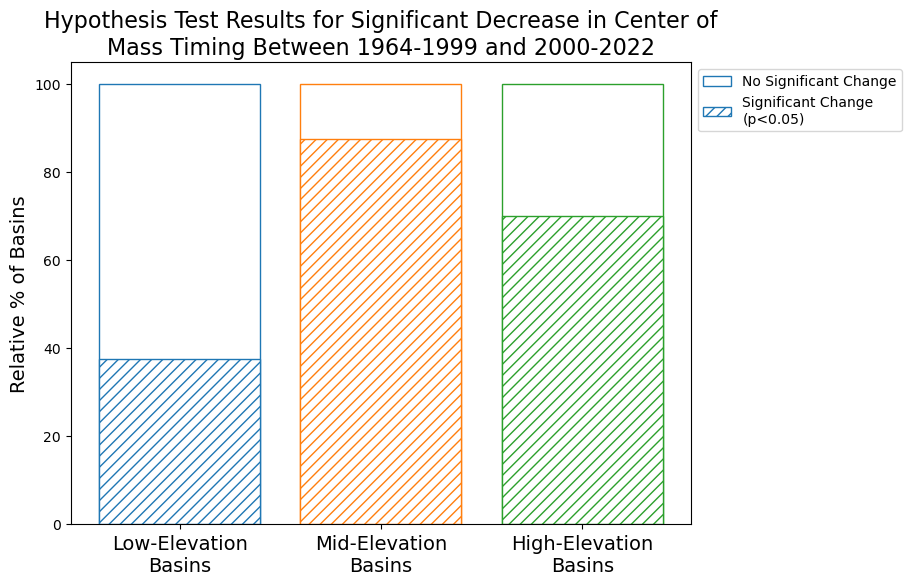

In [23]:

# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

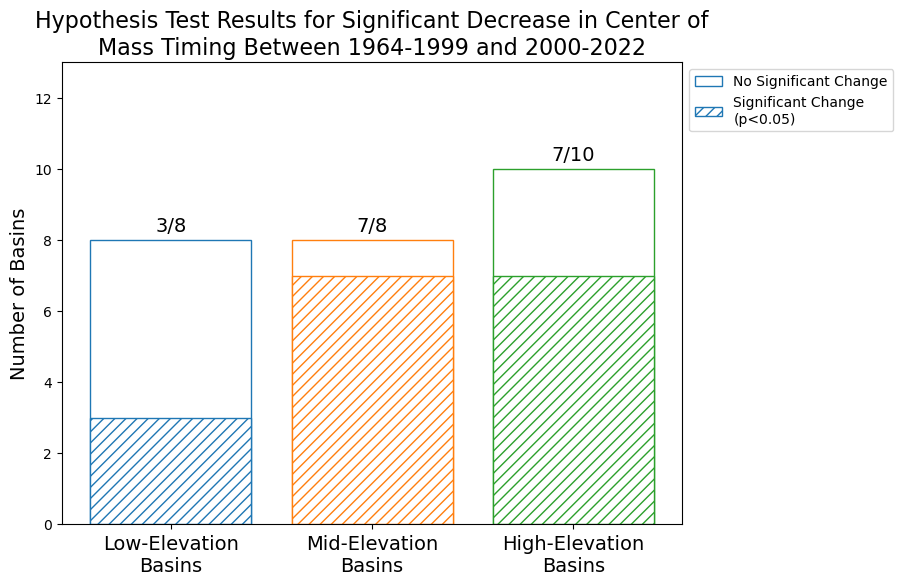

In [26]:
# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[8, 8, 10], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[(low_rejected), (mid_rejected), (high_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in annual mean flow between pre- and post-2000 periods

1) High Elevation Basins

In [27]:
high_meanq_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[1964:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
       
    else:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
     # calculate the percent change between the two periods
    high_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    high_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [28]:
high_meanq_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900        0.211445                                  Probably Gaussian   
09035900        0.062464                                  Probably Gaussian   
09047700        0.013684  Probably GaussianProbably not Gaussian, consid...   
09065500        0.179239                                  Probably Gaussian   
09066000        0.240884                                  Probably Gaussian   
09066200        0.299846                                  Probably Gaussian   
09107000        0.088826                                  Probably Gaussian   
09110000        0.328975                                  Probably Gaussian   
09124500        0.804693                                  Probably Gaussian   
09352900        0.242739                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900    0.046  Null Hypothesis Rejected           NaN   
09035900     0.37  Null Hypothesis Accepted           NaN   
09047700      NaN                       NaN         0.265   
09065500    0.051  Null Hypothesis Accepted           NaN   
09066000    0.121  Null Hypothesis Accepted           NaN   
09066200    0.022  Null Hypothesis Rejected           NaN   
09107000    0.067  Null Hypothesis Accepted           NaN   
09110000    0.003  Null Hypothesis Rejected           NaN   
09124500    0.075  Null Hypothesis Accepted           NaN   
09352900    0.018  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference [mm]  
09034900                       NaN          -10.2                 -70.8  
09035900                       NaN           -2.3                  -9.4  
09047700  Null Hypothesis Accepted          -10.1                 -24.8  
09065500                       NaN          -11.1                 -80.7  
09066000                       NaN           -9.7                 -46.3  
09066200                       NaN          -13.5                 -90.9  
09107000                       NaN          -15.2                 -47.9  
09110000                       NaN          -19.0                 -45.8  
09124500                       NaN          -10.7                 -25.4  
09352900                       NaN          -15.6                -112.2

2) Mid Elevation Basins

In [29]:
mid_meanq_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    mid_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    mid_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round((single_site_post.mean()-single_site_pre.mean()),1)

In [30]:
mid_meanq_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300        0.059042                                  Probably Gaussian   
09081600        0.454766                                  Probably Gaussian   
09112500        0.996541                                  Probably Gaussian   
09115500        0.910503                                  Probably Gaussian   
09119000        0.003218  Probably GaussianProbably not Gaussian, consid...   
09146200        0.964195                                  Probably Gaussian   
09165000        0.040168  Probably GaussianProbably not Gaussian, consid...   
09361500         0.06976                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300    0.021  Null Hypothesis Rejected           NaN   
09081600    0.039  Null Hypothesis Rejected           NaN   
09112500    0.022  Null Hypothesis Rejected           NaN   
09115500    0.125  Null Hypothesis Accepted           NaN   
09119000      NaN                       NaN         0.014   
09146200    0.031  Null Hypothesis Rejected           NaN   
09165000      NaN                       NaN         0.014   
09361500    0.008  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference [mm]  
09066300                       NaN          -18.2                 -61.5  
09081600                       NaN          -12.8                 -80.8  
09112500                       NaN          -16.4                 -66.1  
09115500                       NaN          -12.2                 -18.3  
09119000  Null Hypothesis Rejected          -22.7                 -13.4  
09146200                       NaN          -11.9                 -47.3  
09165000  Null Hypothesis Rejected          -20.6                 -93.3  
09361500                       NaN          -19.5                 -78.8

3) Low Elevation Basins

In [31]:
low_meanq_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    low_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    low_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round((single_site_post.mean()-single_site_pre.mean()),1)

In [32]:
low_meanq_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p  \
09132500        0.214716    Probably Gaussian    0.007   
09147500         0.17333    Probably Gaussian    0.013   
09183500        0.754493    Probably Gaussian    0.004   
09210500         0.25406    Probably Gaussian    0.103   
09223000        0.857539    Probably Gaussian     0.01   
09239500        0.875212    Probably Gaussian    0.098   
09304500        0.783112    Probably Gaussian    0.015   
09312600        0.399327    Probably Gaussian    0.002   

                     t-test Result mannwhitney p mannwhitney Result  \
09132500  Null Hypothesis Rejected           NaN                NaN   
09147500  Null Hypothesis Rejected           NaN                NaN   
09183500  Null Hypothesis Rejected           NaN                NaN   
09210500  Null Hypothesis Accepted           NaN                NaN   
09223000  Null Hypothesis Rejected           NaN                NaN   
09239500  Null Hypothesis Accepted           NaN                NaN   
09304500  Null Hypothesis Rejected           NaN                NaN   
09312600  Null Hypothesis Rejected           NaN                NaN   

         percent change value difference [mm]  
09132500          -22.3                 -72.0  
09147500          -19.2                 -39.6  
09183500          -29.2                 -47.3  
09210500          -13.7                 -23.4  
09223000          -24.5                 -70.1  
09239500          -10.8                 -30.7  
09304500          -15.2                 -43.9  
09312600          -40.6                 -53.7

4. Upper Colorado River Basin

In [33]:
ucrb_meanq_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])

single_site_pre = ucrb_naturalized_streamflow['q_mm_day'].loc[test_start_year:1999]
single_site_post = ucrb_naturalized_streamflow['q_mm_day'].loc[2000:2022]
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_meanq_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_meanq_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [34]:
ucrb_meanq_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p             t-test Result  \
UCRB        0.840977    Probably Gaussian    0.004  Null Hypothesis Rejected   

     mannwhitney p mannwhitney Result  
UCRB           NaN                NaN

Annual Mean Flow Change Plots

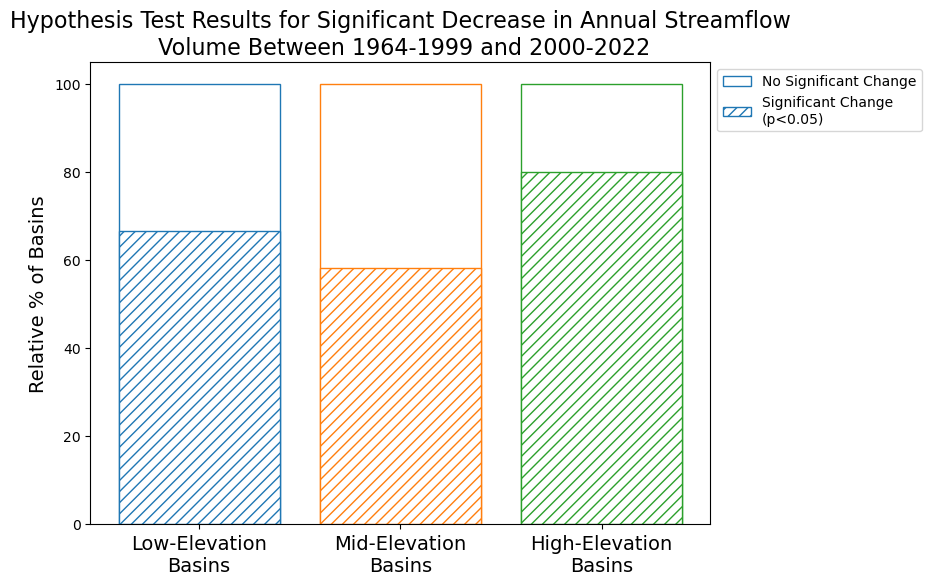

In [35]:

# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

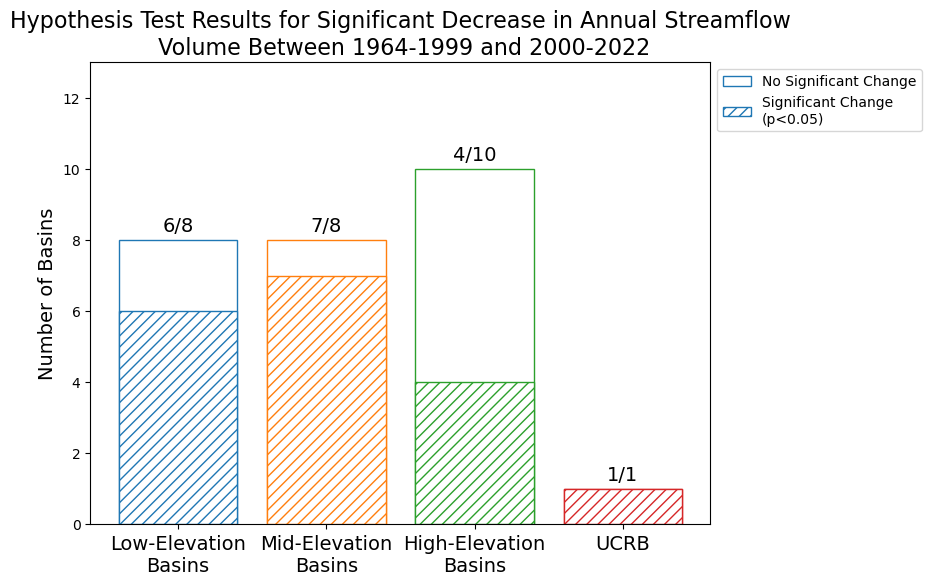

In [37]:
# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
ucrb_rejected = len(ucrb_meanq_ttest_results[(ucrb_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_meanq_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in the distribution of seasonal precipitation in pre- and post-2000 periods

1) High Elevation Basins

Text(0.5, 1.0, 'Summer')

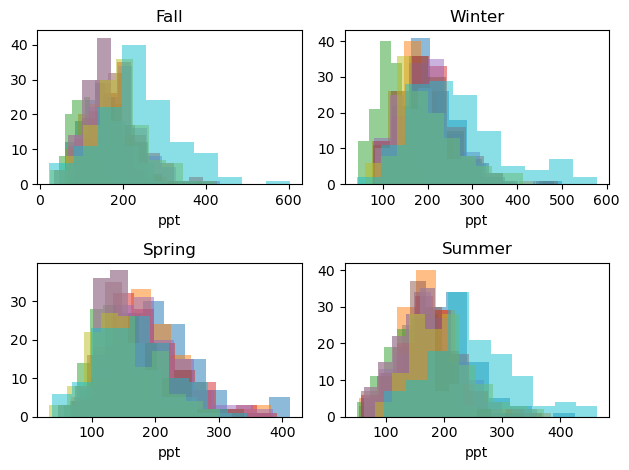

In [38]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in high_elevation_seasonal_ppt.site_no:
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==10,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==1,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==4,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==7,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [39]:
high_fallp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_fallp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    high_fallp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [40]:
high_fallp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900        0.041778  Probably not Gaussian, consider a non-parametr...   
09035900        0.009999  Probably not Gaussian, consider a non-parametr...   
09047700        0.001885  Probably not Gaussian, consider a non-parametr...   
09065500        0.004168  Probably not Gaussian, consider a non-parametr...   
09066000        0.003024  Probably not Gaussian, consider a non-parametr...   
09066200        0.005768  Probably not Gaussian, consider a non-parametr...   
09107000        0.029009  Probably not Gaussian, consider a non-parametr...   
09110000        0.029009  Probably not Gaussian, consider a non-parametr...   
09124500        0.921158                                  Probably Gaussian   
09352900        0.421637                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900      NaN                       NaN         0.748   
09035900      NaN                       NaN         0.748   
09047700      NaN                       NaN         0.716   
09065500      NaN                       NaN         0.456   
09066000      NaN                       NaN         0.351   
09066200      NaN                       NaN         0.637   
09107000      NaN                       NaN         0.273   
09110000      NaN                       NaN         0.273   
09124500     0.06  Null Hypothesis Accepted           NaN   
09352900    0.101  Null Hypothesis Accepted           NaN   

                mannwhitney Result percent change value difference  
09034900  Null Hypothesis Accepted           3.49             5.38  
09035900  Null Hypothesis Accepted           4.19             7.15  
09047700  Null Hypothesis Accepted           2.03             2.12  
09065500  Null Hypothesis Accepted          -0.88             -1.9  
09066000  Null Hypothesis Accepted          -1.84            -3.97  
09066200  Null Hypothesis Accepted           1.62             3.11  
09107000  Null Hypothesis Accepted          -6.61           -11.75  
09110000  Null Hypothesis Accepted          -6.61           -11.75  
09124500                       NaN         -12.97           -27.69  
09352900                       NaN          -12.5           -33.56

In [41]:
high_winterp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
                                                                        
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_winterp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    high_winterp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [42]:
high_winterp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900         0.14438                                  Probably Gaussian   
09035900        0.135202                                  Probably Gaussian   
09047700        0.058654                                  Probably Gaussian   
09065500        0.434048                                  Probably Gaussian   
09066000        0.390388                                  Probably Gaussian   
09066200        0.233995                                  Probably Gaussian   
09107000        0.043231  Probably not Gaussian, consider a non-parametr...   
09110000        0.043231  Probably not Gaussian, consider a non-parametr...   
09124500        0.670906                                  Probably Gaussian   
09352900        0.567766                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900    0.699  Null Hypothesis Accepted           NaN   
09035900    0.797  Null Hypothesis Accepted           NaN   
09047700    0.962  Null Hypothesis Accepted           NaN   
09065500    0.514  Null Hypothesis Accepted           NaN   
09066000    0.593  Null Hypothesis Accepted           NaN   
09066200    0.665  Null Hypothesis Accepted           NaN   
09107000      NaN                       NaN          0.06   
09110000      NaN                       NaN          0.06   
09124500    0.274  Null Hypothesis Accepted           NaN   
09352900     0.24  Null Hypothesis Accepted           NaN   

                mannwhitney Result percent change value difference  
09034900                       NaN           3.63             7.47  
09035900                       NaN           5.61            10.04  
09047700                       NaN          14.79            15.84  
09065500                       NaN           0.23             0.47  
09066000                       NaN           1.55             3.18  
09066200                       NaN           2.77             5.43  
09107000  Null Hypothesis Accepted          -9.75           -19.79  
09110000  Null Hypothesis Accepted          -9.75           -19.79  
09124500                       NaN          -5.29           -10.23  
09352900                       NaN          -7.65            -19.9

In [43]:
high_springp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    high_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    high_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [44]:
high_springp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900        0.006607  Probably not Gaussian, consider a non-parametr...   
09035900        0.020741  Probably not Gaussian, consider a non-parametr...   
09047700        0.001946  Probably not Gaussian, consider a non-parametr...   
09065500        0.002694  Probably not Gaussian, consider a non-parametr...   
09066000        0.003752  Probably not Gaussian, consider a non-parametr...   
09066200        0.000659  Probably not Gaussian, consider a non-parametr...   
09107000         0.00044  Probably not Gaussian, consider a non-parametr...   
09110000         0.00044  Probably not Gaussian, consider a non-parametr...   
09124500        0.221001                                  Probably Gaussian   
09352900        0.704062                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900      NaN                       NaN         0.174   
09035900      NaN                       NaN         0.178   
09047700      NaN                       NaN         0.557   
09065500      NaN                       NaN         0.475   
09066000      NaN                       NaN           0.4   
09066200      NaN                       NaN         0.711   
09107000      NaN                       NaN         0.021   
09110000      NaN                       NaN         0.021   
09124500    0.005  Null Hypothesis Rejected           NaN   
09352900    0.001  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference  
09034900  Null Hypothesis Accepted          -12.0            -26.5  
09035900  Null Hypothesis Accepted          -11.2            -22.8  
09047700  Null Hypothesis Accepted           -4.5             -6.4  
09065500  Null Hypothesis Accepted           -6.9            -13.6  
09066000  Null Hypothesis Accepted           -8.8            -18.0  
09066200  Null Hypothesis Accepted           -1.2             -2.1  
09107000  Null Hypothesis Rejected          -17.0            -27.1  
09110000  Null Hypothesis Rejected          -17.0            -27.1  
09124500                       NaN          -21.3            -34.1  
09352900                       NaN          -26.2            -47.8

In [45]:
high_summerp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'
                                                                                    ])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        high_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_summerp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    high_summerp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)
    

In [46]:
high_summerp_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p  \
09034900        0.209093    Probably Gaussian    0.524   
09035900         0.13881    Probably Gaussian    0.541   
09047700        0.447565    Probably Gaussian    0.362   
09065500        0.737943    Probably Gaussian    0.485   
09066000        0.600307    Probably Gaussian      0.4   
09066200        0.558447    Probably Gaussian    0.476   
09107000        0.765622    Probably Gaussian    0.433   
09110000        0.765622    Probably Gaussian    0.433   
09124500        0.449996    Probably Gaussian    0.776   
09352900          0.2127    Probably Gaussian    0.947   

                     t-test Result mannwhitney p mannwhitney Result  \
09034900  Null Hypothesis Accepted           NaN                NaN   
09035900  Null Hypothesis Accepted           NaN                NaN   
09047700  Null Hypothesis Accepted           NaN                NaN   
09065500  Null Hypothesis Accepted           NaN                NaN   
09066000  Null Hypothesis Accepted           NaN                NaN   
09066200  Null Hypothesis Accepted           NaN                NaN   
09107000  Null Hypothesis Accepted           NaN                NaN   
09110000  Null Hypothesis Accepted           NaN                NaN   
09124500  Null Hypothesis Accepted           NaN                NaN   
09352900  Null Hypothesis Accepted           NaN                NaN   

         percent change value difference  
09034900          -0.51             -1.0  
09035900          -0.78            -1.34  
09047700           2.81             4.18  
09065500            0.3             0.54  
09066000           2.08              3.8  
09066200           0.44             0.72  
09107000           1.21             1.87  
09110000           1.21             1.87  
09124500          -5.68           -11.47  
09352900         -12.99           -34.24

2) Mid Elevation Basins

Text(0.5, 1.0, 'Summer')

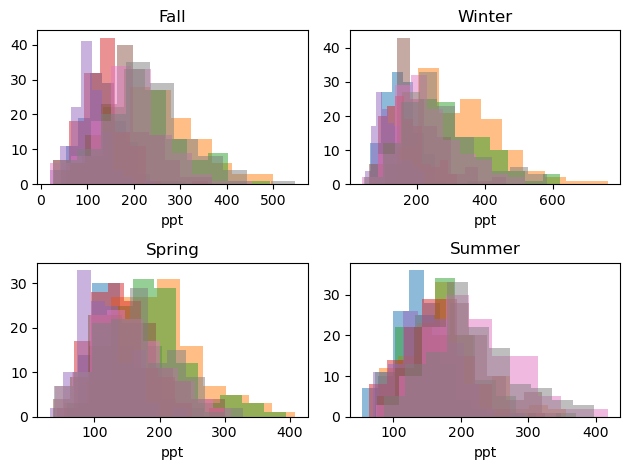

In [47]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in mid_elevation_seasonal_ppt.site_no:
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==10,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==1,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==4,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==7,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [48]:
mid_fallp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_fallp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    mid_fallp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [49]:
mid_fallp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300        0.008756  Probably not Gaussian, consider a non-parametr...   
09081600         0.88399                                  Probably Gaussian   
09112500        0.289883                                  Probably Gaussian   
09115500        0.003514  Probably not Gaussian, consider a non-parametr...   
09119000        0.256384                                  Probably Gaussian   
09146200        0.812212                                  Probably Gaussian   
09165000        0.840939                                  Probably Gaussian   
09361500        0.611295                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300      NaN                       NaN         0.582   
09081600    0.058  Null Hypothesis Accepted           NaN   
09112500    0.026  Null Hypothesis Rejected           NaN   
09115500      NaN                       NaN         0.204   
09119000    0.092  Null Hypothesis Accepted           NaN   
09146200    0.044  Null Hypothesis Rejected           NaN   
09165000     0.08  Null Hypothesis Accepted           NaN   
09361500    0.066  Null Hypothesis Accepted           NaN   

                mannwhitney Result percent change value difference  
09066300  Null Hypothesis Accepted           1.01             1.54  
09081600                       NaN         -12.22           -36.09  
09112500                       NaN         -14.85           -39.51  
09115500  Null Hypothesis Accepted          -8.65           -13.11  
09119000                       NaN         -10.01           -11.62  
09146200                       NaN         -13.16           -27.37  
09165000                       NaN         -13.08           -28.85  
09361500                       NaN         -14.14           -36.51

In [50]:
mid_winterp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_winterp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    mid_winterp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [51]:
mid_winterp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300        0.212436                                  Probably Gaussian   
09081600        0.014797  Probably not Gaussian, consider a non-parametr...   
09112500        0.043536  Probably not Gaussian, consider a non-parametr...   
09115500        0.144279                                  Probably Gaussian   
09119000         0.29379                                  Probably Gaussian   
09146200        0.979016                                  Probably Gaussian   
09165000        0.451413                                  Probably Gaussian   
09361500        0.627421                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300    0.845  Null Hypothesis Accepted           NaN   
09081600      NaN                       NaN         0.012   
09112500      NaN                       NaN         0.014   
09115500    0.143  Null Hypothesis Accepted           NaN   
09119000    0.222  Null Hypothesis Accepted           NaN   
09146200    0.366  Null Hypothesis Accepted           NaN   
09165000    0.183  Null Hypothesis Accepted           NaN   
09361500     0.21  Null Hypothesis Accepted           NaN   

                mannwhitney Result percent change value difference  
09066300                       NaN           7.42            11.13  
09081600  Null Hypothesis Rejected         -15.62           -52.59  
09112500  Null Hypothesis Rejected         -15.78           -47.73  
09115500                       NaN          -9.59           -16.51  
09119000                       NaN          -6.91            -8.36  
09146200                       NaN          -2.82            -5.45  
09165000                       NaN          -9.38           -21.82  
09361500                       NaN          -8.33           -21.79

In [52]:
mid_springp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)]
    single_site_post = mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    mid_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    mid_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [53]:
mid_springp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300        0.000207  Probably not Gaussian, consider a non-parametr...   
09081600        0.039817  Probably not Gaussian, consider a non-parametr...   
09112500        0.002003  Probably not Gaussian, consider a non-parametr...   
09115500        0.030445  Probably not Gaussian, consider a non-parametr...   
09119000        0.030682  Probably not Gaussian, consider a non-parametr...   
09146200         0.37868                                  Probably Gaussian   
09165000        0.286937                                  Probably Gaussian   
09361500        0.202946                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300      NaN                       NaN         0.727   
09081600      NaN                       NaN         0.043   
09112500      NaN                       NaN         0.014   
09115500      NaN                       NaN         0.007   
09119000      NaN                       NaN         0.003   
09146200    0.007  Null Hypothesis Rejected           NaN   
09165000    0.002  Null Hypothesis Rejected           NaN   
09361500    0.004  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference  
09066300  Null Hypothesis Accepted            0.2              0.3  
09081600  Null Hypothesis Rejected          -16.0            -34.2  
09112500  Null Hypothesis Rejected          -19.9            -40.2  
09115500  Null Hypothesis Rejected          -18.1            -26.9  
09119000  Null Hypothesis Rejected          -20.9            -25.1  
09146200                       NaN          -21.1            -34.9  
09165000                       NaN          -24.9            -40.6  
09361500                       NaN          -23.6            -40.5

In [54]:
mid_summerp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        mid_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_summerp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    mid_summerp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [55]:
mid_summerp_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p  \
09066300        0.053573    Probably Gaussian    0.267   
09081600        0.126802    Probably Gaussian    0.274   
09112500        0.806824    Probably Gaussian    0.398   
09115500         0.25064    Probably Gaussian    0.782   
09119000        0.309295    Probably Gaussian    0.832   
09146200        0.597809    Probably Gaussian    0.735   
09165000         0.35037    Probably Gaussian    0.879   
09361500         0.28901    Probably Gaussian    0.918   

                     t-test Result mannwhitney p mannwhitney Result  \
09066300  Null Hypothesis Accepted           NaN                NaN   
09081600  Null Hypothesis Accepted           NaN                NaN   
09112500  Null Hypothesis Accepted           NaN                NaN   
09115500  Null Hypothesis Accepted           NaN                NaN   
09119000  Null Hypothesis Accepted           NaN                NaN   
09146200  Null Hypothesis Accepted           NaN                NaN   
09165000  Null Hypothesis Accepted           NaN                NaN   
09361500  Null Hypothesis Accepted           NaN                NaN   

         percent change value difference  
09066300            4.7             6.46  
09081600           5.11             9.33  
09112500           2.01             3.43  
09115500          -5.73            -9.58  
09119000          -6.57           -10.21  
09146200          -4.65            -9.18  
09165000           -9.0           -20.33  
09361500         -10.69           -24.46

3) Low Elevation Basins

Text(0.5, 1.0, 'Summer')

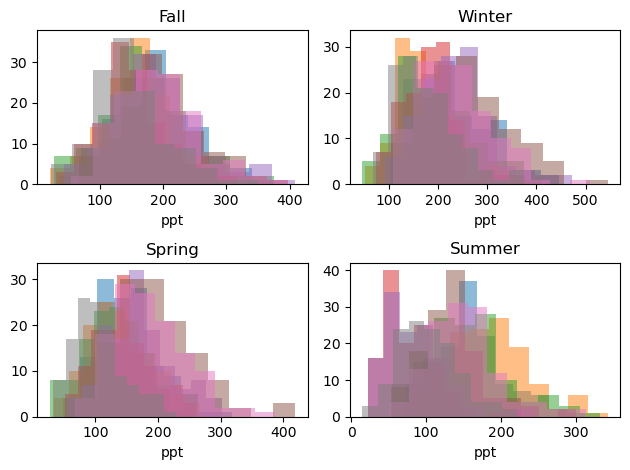

In [56]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in low_elevation_seasonal_ppt.site_no:
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==10,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==1,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==4,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==7,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [57]:
low_fallp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_fallp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    low_fallp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [58]:
low_fallp_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p  \
09132500        0.644028    Probably Gaussian    0.102   
09147500        0.799912    Probably Gaussian    0.054   
09183500        0.919712    Probably Gaussian    0.129   
09210500        0.502821    Probably Gaussian    0.147   
09223000        0.633915    Probably Gaussian    0.141   
09239500        0.346597    Probably Gaussian    0.091   
09304500        0.111587    Probably Gaussian    0.011   
09312600        0.187166    Probably Gaussian    0.431   

                     t-test Result mannwhitney p mannwhitney Result  \
09132500  Null Hypothesis Accepted           NaN                NaN   
09147500  Null Hypothesis Accepted           NaN                NaN   
09183500  Null Hypothesis Accepted           NaN                NaN   
09210500  Null Hypothesis Accepted           NaN                NaN   
09223000  Null Hypothesis Accepted           NaN                NaN   
09239500  Null Hypothesis Accepted           NaN                NaN   
09304500  Null Hypothesis Rejected           NaN                NaN   
09312600  Null Hypothesis Accepted           NaN                NaN   

         percent change value difference  
09132500          -9.87           -21.02  
09147500         -12.59           -22.72  
09183500         -12.03           -23.06  
09210500          -8.55           -14.84  
09223000          -8.88           -19.47  
09239500           -8.4           -18.68  
09304500         -15.27           -34.38  
09312600           -1.8            -2.91

In [59]:
low_winterp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_winterp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    low_winterp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [60]:
low_winterp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09132500        0.061069                                  Probably Gaussian   
09147500        0.975688                                  Probably Gaussian   
09183500        0.286455                                  Probably Gaussian   
09210500        0.756451                                  Probably Gaussian   
09223000        0.856316                                  Probably Gaussian   
09239500        0.919609                                  Probably Gaussian   
09304500        0.493703                                  Probably Gaussian   
09312600          0.0204  Probably not Gaussian, consider a non-parametr...   

         t-test p             t-test Result mannwhitney p  \
09132500    0.086  Null Hypothesis Accepted           NaN   
09147500     0.34  Null Hypothesis Accepted           NaN   
09183500    0.075  Null Hypothesis Accepted           NaN   
09210500    0.181  Null Hypothesis Accepted           NaN   
09223000    0.169  Null Hypothesis Accepted           NaN   
09239500    0.046  Null Hypothesis Rejected           NaN   
09304500    0.001  Null Hypothesis Rejected           NaN   
09312600      NaN                       NaN         0.158   

                mannwhitney Result percent change value difference  
09132500                       NaN         -10.45           -23.57  
09147500                       NaN          -3.42            -5.78  
09183500                       NaN         -15.06           -28.98  
09210500                       NaN          -7.66           -14.65  
09223000                       NaN          -7.86           -19.47  
09239500                       NaN         -10.25           -26.91  
09304500                       NaN         -17.94            -43.9  
09312600  Null Hypothesis Accepted          -8.32           -14.68

In [68]:
low_springp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < 0.1:
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < 0.1:
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    low_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    low_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [69]:
low_springp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09132500        0.019753  Probably not Gaussian, consider a non-parametr...   
09147500         0.47172                                  Probably Gaussian   
09183500        0.930841                                  Probably Gaussian   
09210500        0.874262                                  Probably Gaussian   
09223000        0.718313                                  Probably Gaussian   
09239500        0.107288                                  Probably Gaussian   
09304500        0.057162  Probably not Gaussian, consider a non-parametr...   
09312600        0.321534                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09132500      NaN                       NaN         0.054   
09147500    0.005  Null Hypothesis Rejected           NaN   
09183500    0.003  Null Hypothesis Rejected           NaN   
09210500    0.146  Null Hypothesis Accepted           NaN   
09223000    0.229  Null Hypothesis Accepted           NaN   
09239500    0.059  Null Hypothesis Rejected           NaN   
09304500      NaN                       NaN         0.022   
09312600    0.043  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference  
09132500  Null Hypothesis Rejected          -15.2            -24.8  
09147500                       NaN          -22.3            -33.2  
09183500                       NaN          -26.4            -37.3  
09210500                       NaN           -8.5            -13.6  
09223000                       NaN           -5.9            -11.1  
09239500                       NaN          -12.1            -25.3  
09304500  Null Hypothesis Rejected          -18.5            -37.6  
09312600                       NaN          -15.1            -18.5

In [70]:
low_summerp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
                                                                          
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_summerp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    low_summerp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [71]:
low_summerp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09132500         0.32462                                  Probably Gaussian   
09147500        0.526847                                  Probably Gaussian   
09183500        0.223625                                  Probably Gaussian   
09210500        0.020628  Probably not Gaussian, consider a non-parametr...   
09223000        0.031634  Probably not Gaussian, consider a non-parametr...   
09239500         0.00343  Probably not Gaussian, consider a non-parametr...   
09304500        0.021147  Probably not Gaussian, consider a non-parametr...   
09312600        0.081404  Probably not Gaussian, consider a non-parametr...   

         t-test p             t-test Result mannwhitney p  \
09132500    0.672  Null Hypothesis Accepted           NaN   
09147500    0.278  Null Hypothesis Accepted           NaN   
09183500    0.443  Null Hypothesis Accepted           NaN   
09210500      NaN                       NaN         0.088   
09223000      NaN                       NaN         0.117   
09239500      NaN                       NaN         0.322   
09304500      NaN                       NaN         0.582   
09312600      NaN                       NaN         0.294   

                mannwhitney Result percent change value difference  
09132500                       NaN            3.6             5.83  
09147500                       NaN          -4.35            -8.27  
09183500                       NaN          -1.51            -2.45  
09210500  Null Hypothesis Rejected         -15.84           -13.99  
09223000  Null Hypothesis Accepted          -13.9           -13.52  
09239500  Null Hypothesis Accepted          -4.22            -5.87  
09304500  Null Hypothesis Accepted          -0.59            -0.91  
09312600  Null Hypothesis Accepted           -1.1             -1.2

4. Upper Colorado River Basin

In [72]:
# Seasonal Precipitation Plot
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.month.dt.days_in_month

    # Calculate the weighted average
    return (ds).resample(month='QS-OCT').mean() * 3

In [73]:
ucrb_ppt_seasonal_mean = season_mean(p_mean.drop('WY'))
ucrb_ppt_seasonal_mean['WY'] = ucrb_ppt_seasonal_mean.month.dt.year.where(ucrb_ppt_seasonal_mean.month.dt.month<10, ucrb_ppt_seasonal_mean.month.dt.year+1)

Text(0.5, 1.0, 'Summer')

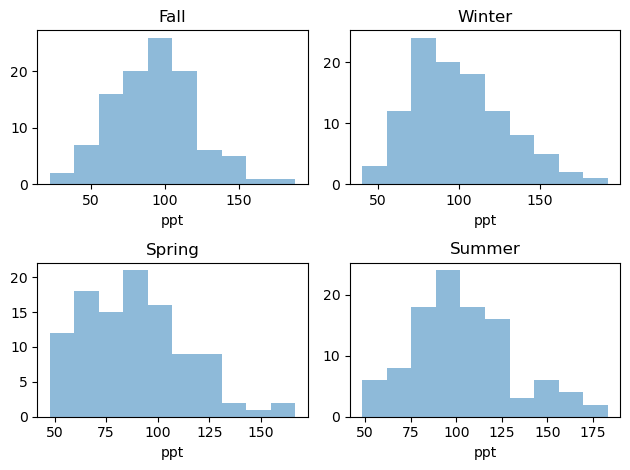

In [74]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()

ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==10),drop=True)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==1),drop=True)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==4),drop=True)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==7),drop=True)['ppt'].plot.hist(ax=axs[3], alpha=0.5)

axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

<AxesSubplot: xlabel='month'>

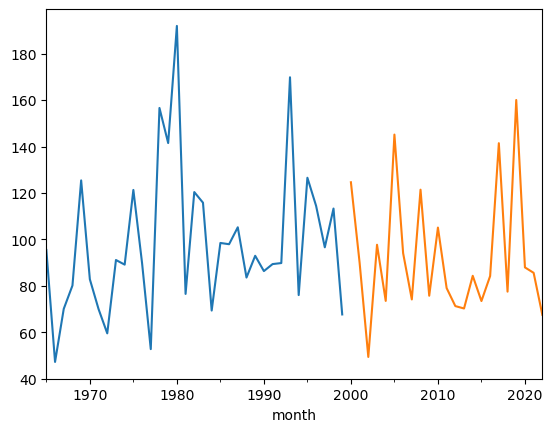

In [75]:
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==1),drop=True)['ppt'].to_pandas().loc[dt.date(test_start_year,9,30):dt.date(1999,9,30)].plot()
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==1),drop=True)['ppt'].to_pandas().loc[dt.date(1999,9,30):].plot()

In [76]:
season_list = ['fall','winter','spring','summer']
ucrb_seasonalppt_ttest_results = pd.DataFrame(index=season_list, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change (spring)',
                                                                                    'value difference (spring)'])
seasons = [ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==10),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==1),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==4),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==7),drop=True)['ppt'].to_pandas()]
for i,ds_seas in enumerate(seasons):
    single_site_pre = (ds_seas.loc[dt.date(test_start_year,9,30):dt.date(1999,9,30)])
    single_site_post = (ds_seas.loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke p'] = p

    if p > 100:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably Gaussian'
        if season_list[i] =='summer':
            # run the test for 1-conf
            z_alpha = stats.norm.ppf(conf)
        else:
            z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        if season_list[i] =='summer':
            # run the test for 1-conf
            pvalue = 1-stats.norm.cdf(z_test)
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue > 1-conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
        else:
            pvalue = stats.norm.cdf(z_test)
        
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue < conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        if season_list[i] =='summer':
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        else:
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Accepted'
    if i==2:
        # calculate the percent change between the two periods
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'percent change (spring)'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
        # calculate the difference in the mean values between the two periods
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'value difference (spring)'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [77]:
ucrb_seasonalppt_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
fall           0.85416  Probably not Gaussian, consider a non-parametr...   
winter        0.034494  Probably not Gaussian, consider a non-parametr...   
spring        0.325041  Probably not Gaussian, consider a non-parametr...   
summer        0.422086  Probably not Gaussian, consider a non-parametr...   

       t-test p t-test Result mannwhitney p        mannwhitney Result  \
fall        NaN           NaN          0.14  Null Hypothesis Accepted   
winter      NaN           NaN         0.191  Null Hypothesis Accepted   
spring      NaN           NaN         0.009  Null Hypothesis Rejected   
summer      NaN           NaN         0.317  Null Hypothesis Accepted   

       percent change (spring) value difference (spring)  
fall                       NaN                       NaN  
winter                     NaN                       NaN  
spring                   -17.3                     -16.4  
summer                     NaN                       NaN

### Winter Precipitation Shift Results

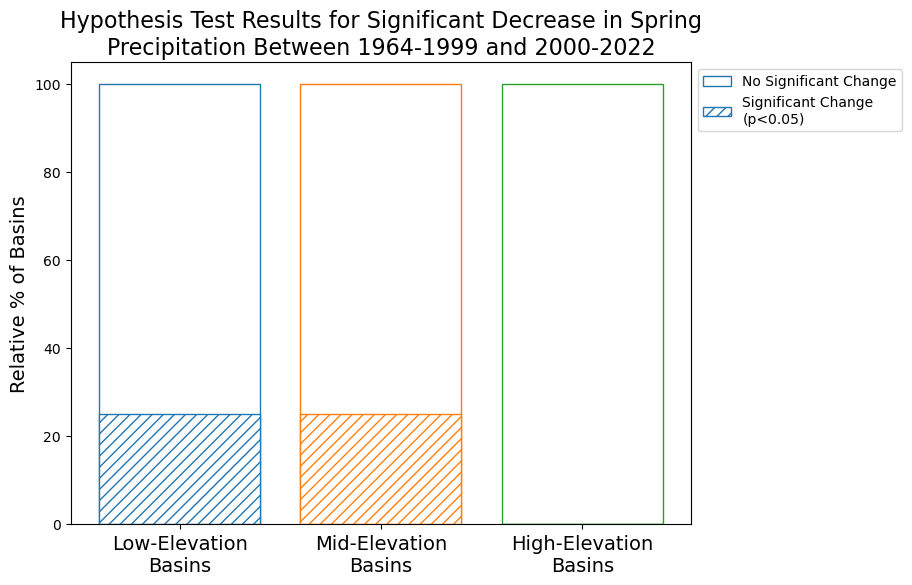

In [78]:

# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

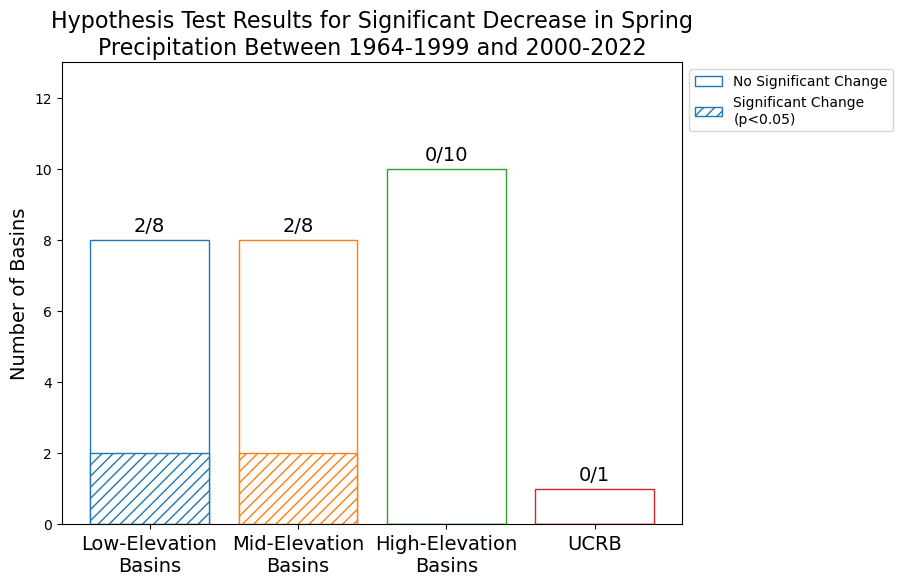

In [80]:
# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='winter']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Spring Precipitation Shift Results

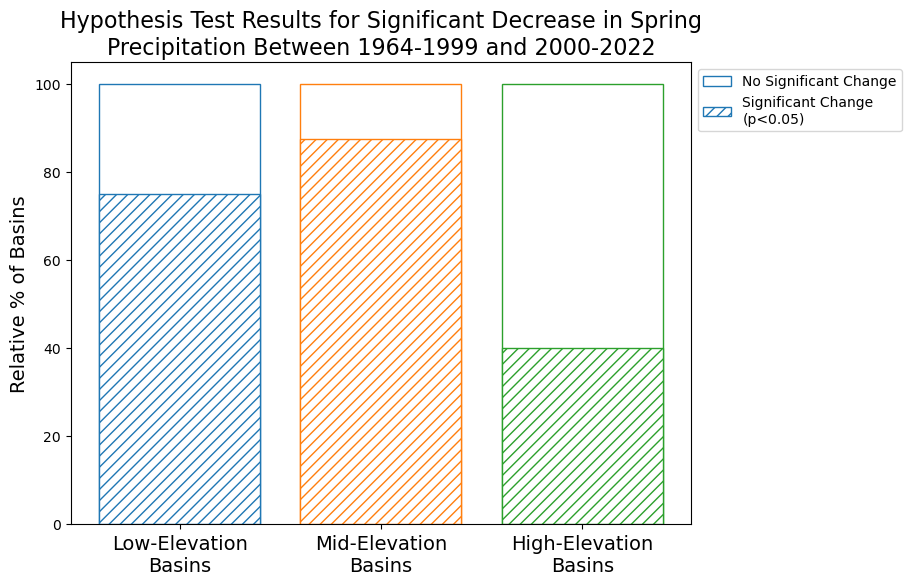

In [81]:

# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.10)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.10)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

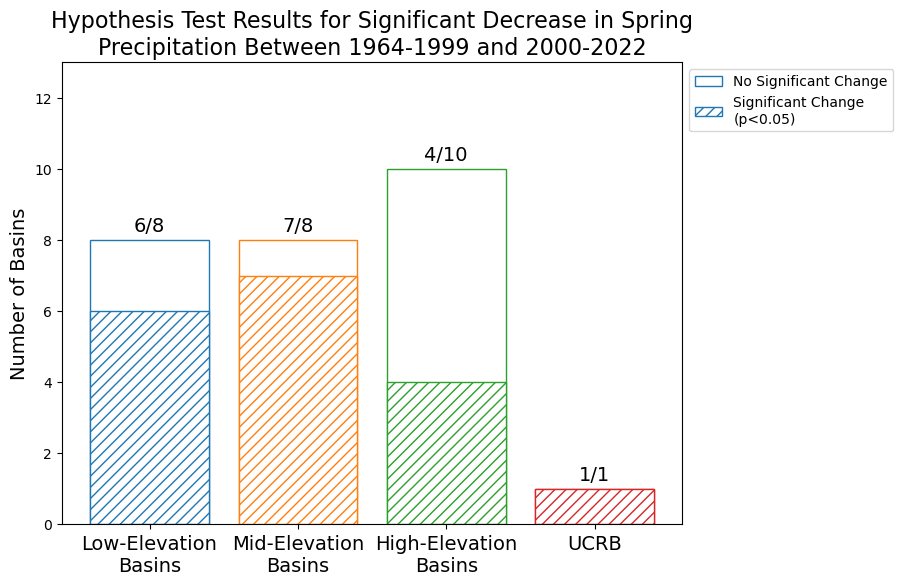

In [82]:
# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.1)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.1)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.1)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='spring']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.1)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Summer Precipitation Shift Results

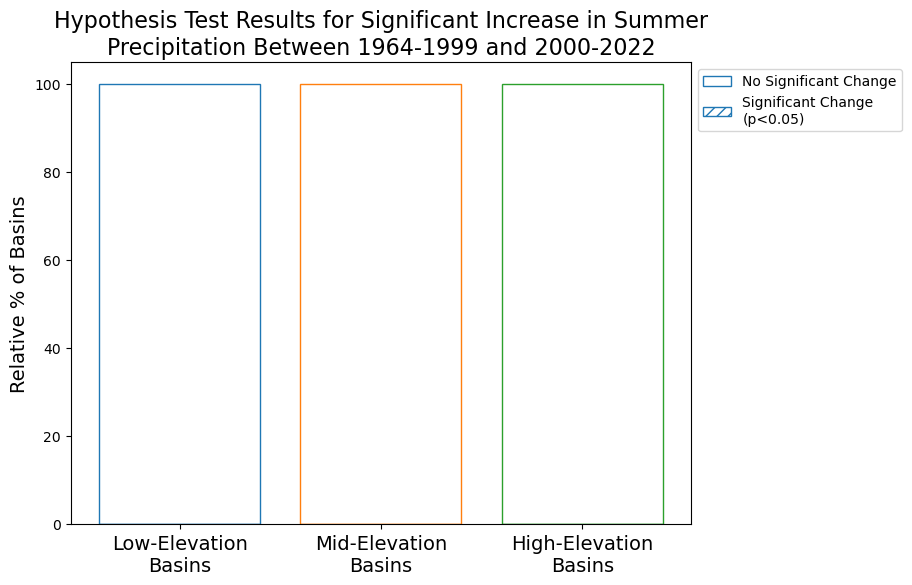

In [84]:

# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/len(low_summerp_ttest_results)), 100*(mid_rejected/len(mid_summerp_ttest_results)), 100*(high_rejected/len(high_summerp_ttest_results))], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Increase in Summer\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



In [214]:
print(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)].index)
print(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)].index)
print(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)].index)

Index(['09119000', '09147500', '09210500', '09223000', '09239500', '09304500'], dtype='object')
Index(['09115500', '09124500', '09146200', '09165000', '09361500'], dtype='object')
Index(['09352900'], dtype='object')


(0.0, 13.0)

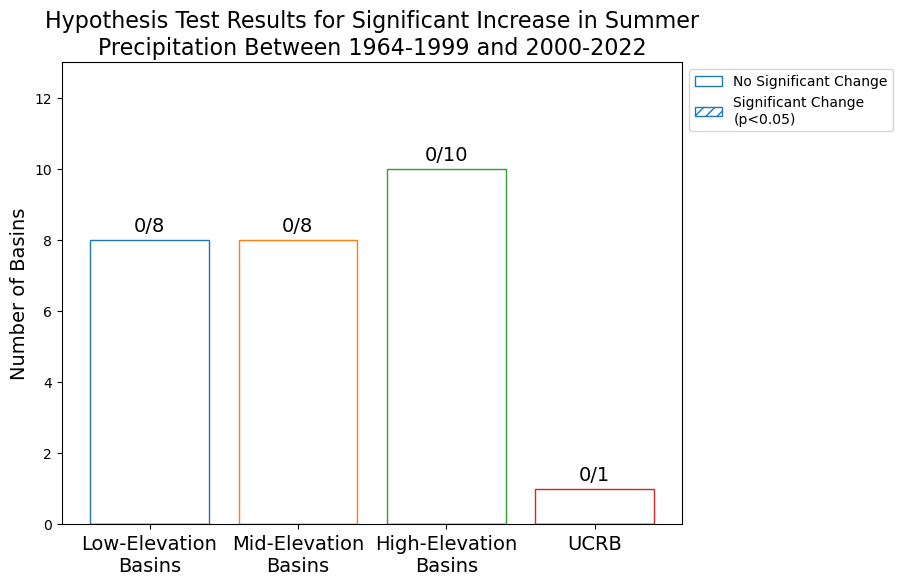

In [85]:
# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='summer']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Increase in Summer\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

In [216]:

# # scatter plot of ppt against high_elevation_annual_q q_mm
# fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(x=high_elevation_springp['ppt'].values, y=high_elevation_annual_q['q_mm'].values, alpha=0.5)
# ax.scatter(x=high_elevation_winterp['ppt'].values, y=high_elevation_annual_q['q_mm'].values, alpha=0.5)


### Look at spring P and streamflow relationship

In [86]:
hcdn_monthly_prism_precip_ds = xr.open_dataset('../data/precipdata/hcdn_monthly_prism_precip.nc')
hcdn_monthly_prism_precip_ds = hcdn_monthly_prism_precip_ds.merge(basin_group_da)
high_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==2, drop=True)
mid_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==0, drop=True)
low_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==1, drop=True)

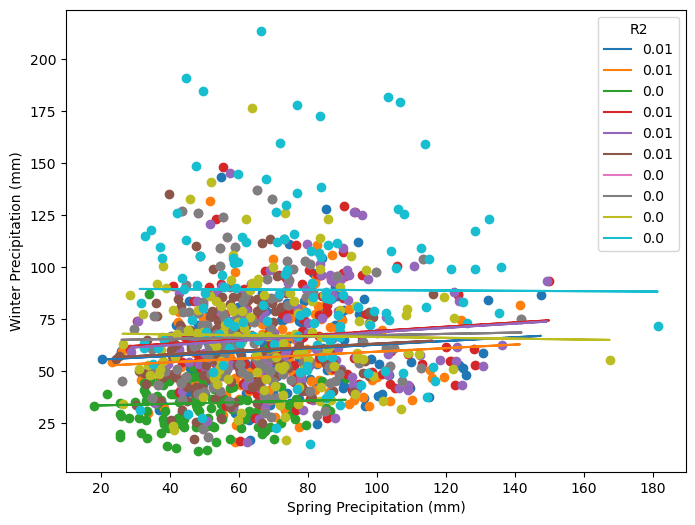

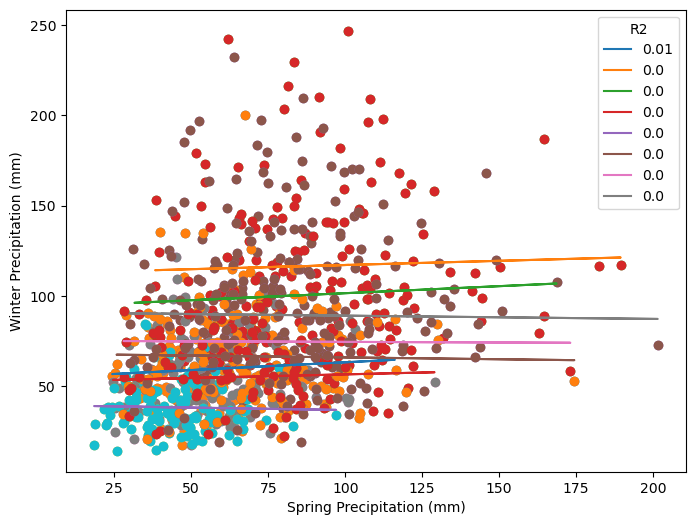

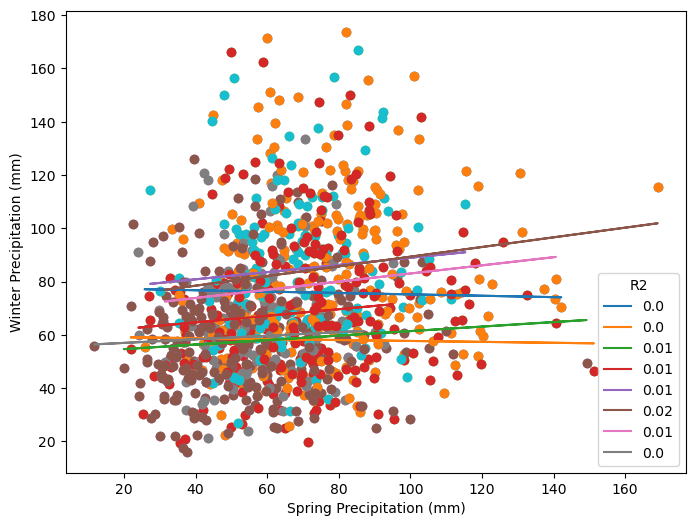

In [87]:
# plot high elevation seasonal precipitation for month = 3
# iterate through the site_no and plot the seasonal ppt vs annual q
# plot the seasonal ppt vs annual q for the site_no = 1
high_winter_spring_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in high_monthly_ppt.site_no:
    annualq = high_monthly_ppt.where((high_monthly_ppt['month'].dt.month.isin([12,1,2])), drop=True).ppt.sel(site_no=site)
    # add water year to annualq
    annualq['WY'] = annualq['month'].dt.year.where(annualq['month'].dt.month<10, annualq['month'].dt.year+1)
    annualq = annualq.groupby('WY').mean().values

    springp = high_monthly_ppt.where((high_monthly_ppt['month'].dt.month.isin([3,4,5])), drop=True).ppt.sel(site_no=site, )
    # add water year to springp
    springp['WY'] = springp['month'].dt.year.where(springp['month'].dt.month<10, springp['month'].dt.year+1)
    springp = springp.groupby('WY').mean().values
    plt.scatter(springp,
                annualq)
    # add a best fit line using linregress
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    high_winter_spring_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')
plt.legend(title='R2')

mid_winter_spring_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in mid_monthly_ppt.site_no:
    annualq = mid_monthly_ppt.where((mid_monthly_ppt['month'].dt.month.isin([12,1,2])), drop=True).ppt.sel(site_no=site)
    # add water year to annualq
    annualq['WY'] = annualq['month'].dt.year.where(annualq['month'].dt.month<10, annualq['month'].dt.year+1)
    annualq = annualq.groupby('WY').mean().values

    springp = mid_monthly_ppt.where((mid_monthly_ppt['month'].dt.month.isin([3,4,5])), drop=True).ppt.sel(site_no=site, )
    # add water year to springp
    springp['WY'] = springp['month'].dt.year.where(springp['month'].dt.month<10, springp['month'].dt.year+1)
    springp = springp.groupby('WY').mean().values
    plt.scatter(springp,
                annualq)
    plt.scatter(springp,
                annualq)
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    mid_winter_spring_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.legend(title='R2')
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')

# figure for low elevation basins
low_winter_spring_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in low_monthly_ppt.site_no:
    annualq = low_monthly_ppt.where((low_monthly_ppt['month'].dt.month.isin([12,1,2])), drop=True).ppt.sel(site_no=site)
    # add water year to annualq
    annualq['WY'] = annualq['month'].dt.year.where(annualq['month'].dt.month<10, annualq['month'].dt.year+1)
    annualq = annualq.groupby('WY').mean().values

    springp = low_monthly_ppt.where((low_monthly_ppt['month'].dt.month.isin([3,4,5])), drop=True).ppt.sel(site_no=site, )
    # add water year to springp
    springp['WY'] = springp['month'].dt.year.where(springp['month'].dt.month<10, springp['month'].dt.year+1)
    springp = springp.groupby('WY').mean().values
    plt.scatter(springp,
                annualq)
    plt.scatter(springp,
                annualq)
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    low_winter_spring_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')
plt.legend(title='R2')

(0.0, 70.0)

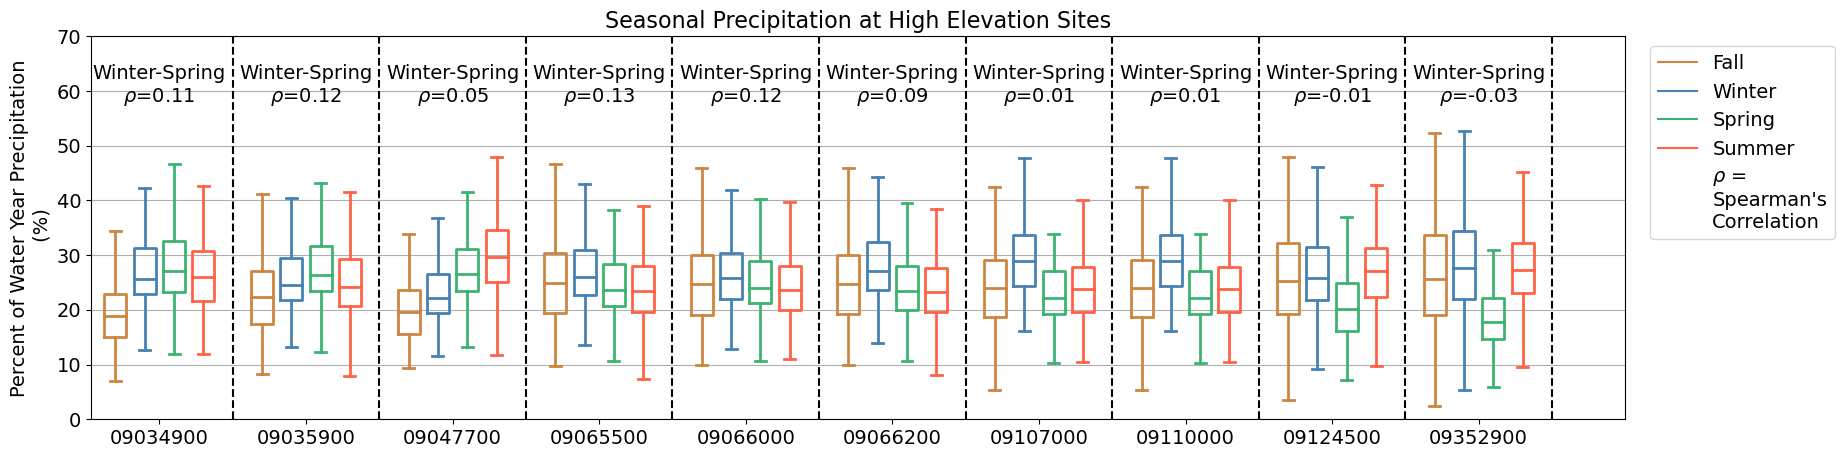

In [94]:
# create boxplot for high elevation data with a box
annual_ppt = high_elevation_annual_ppt.ppt
fall = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 10), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 1), drop=True).ppt.values.T/annual_ppt)
spring = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
summer = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 7), drop=True).ppt.values.T/annual_ppt)

ticks = high_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(18,5))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
# set box colors
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+7,len(ticks))
plt.xticks(np.linspace(0,len(ticks)*2+7,len(ticks)), ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(high_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-Spring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at High Elevation Sites', size=16)
plt.ylim(0,70)


In [220]:
# # import cycler
# from cycler import cycler
# # boxplots of precipitation by month 
# # create boxplot for high elevation data with a box
# annual_ppt = high_monthly_ppt.groupby('month.year').sum()['ppt']
# february = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 2), drop=True).ppt.values.T/annual_ppt)
# march = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 3), drop=True).ppt.values.T/annual_ppt)
# april = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
# may = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 5), drop=True).ppt.values.T/annual_ppt)

# ticks = high_monthly_ppt.site_no.values

# def set_box_color(bp, color):
#     plt.setp(bp['boxes'], color=color, linewidth=2)
#     plt.setp(bp['whiskers'], color=color, linewidth=2)
#     plt.setp(bp['caps'], color=color, linewidth=2)
#     plt.setp(bp['medians'], color=color, linewidth=2)

# plt.figure(figsize=(15,5))

# february_box = plt.boxplot(february, positions=np.array(range(len(february.T)))*3.-0.9, sym='', widths=0.45,)
# march_box = plt.boxplot(march, positions=np.array(range(len(march.T)))*3.-0.3, sym='', widths=0.45,)
# april_box = plt.boxplot(april, positions=np.array(range(len(april.T)))*3.+0.3, sym='', widths=0.45,)
# may_box = plt.boxplot(may, positions=np.array(range(len(may.T)))*3.+0.9, sym='', widths=0.45,)
# # add vertical lines between each tick
# for val in np.array(range(len(may.T)))*3.+1.5:
#     vertical_line = plt.axvline(x=val, color='k', linestyle='--')
# # create a colorcycler from the winter colormap
# cc = plt.cm.winter(np.linspace(0, 1,4))
# # set box colors
# set_box_color(february_box, cc[0]) # colors are from http://colorbrewer2.org/
# set_box_color(march_box, cc[1])
# set_box_color(april_box, cc[2])
# set_box_color(may_box, cc[3])

# # draw temporary red and blue lines and use them to create a legend
# plt.plot([], c=cc[0], label='February')
# plt.plot([], c=cc[1], label='March')
# plt.plot([], c=cc[2], label='April')
# plt.plot([], c=cc[3], label='May')
# plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
# plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# # set x-ticks
# tick_spacing = np.linspace(0,len(ticks)*2+2,len(ticks))
# plt.xticks(np.linspace(0,len(ticks)*2+2,len(ticks)), ticks, size=14)
# # add the high_march_april_corr to the plot as text above each tick
# for i, val in enumerate(high_march_april_corr):
#     plt.text(tick_spacing[i], 30, "March-April\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# # add horizontal grid lines
# plt.grid(axis='y')
# plt.tight_layout()
# # increase y-axis label size 
# plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# # increase y-tick label size
# plt.yticks(size=14)
# plt.title('Seasonal Precipitation at High Elevation Sites', size=16)
# plt.ylim(0,35)


(0.0, 70.0)

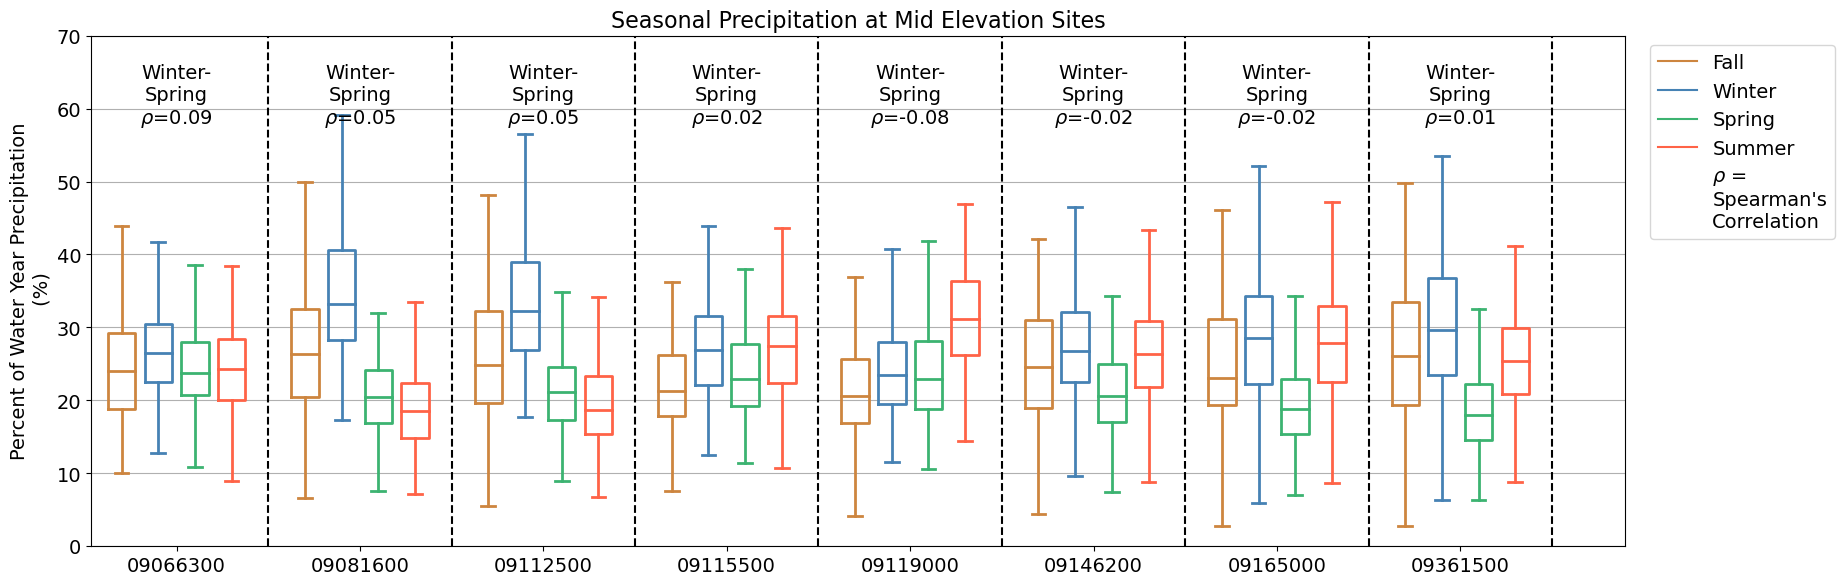

In [90]:
# create boxplot for mid elevation data with a box
annual_ppt = mid_elevation_annual_ppt.ppt
fall = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 10), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 1), drop=True).ppt.values.T/annual_ppt)
spring = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
summer = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 7), drop=True).ppt.values.T/annual_ppt)

ticks = mid_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(18,6))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+5,len(ticks))
plt.xticks(tick_spacing, ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(mid_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-\nSpring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at Mid Elevation Sites', size=16)
plt.ylim(0,70)


(0.0, 70.0)

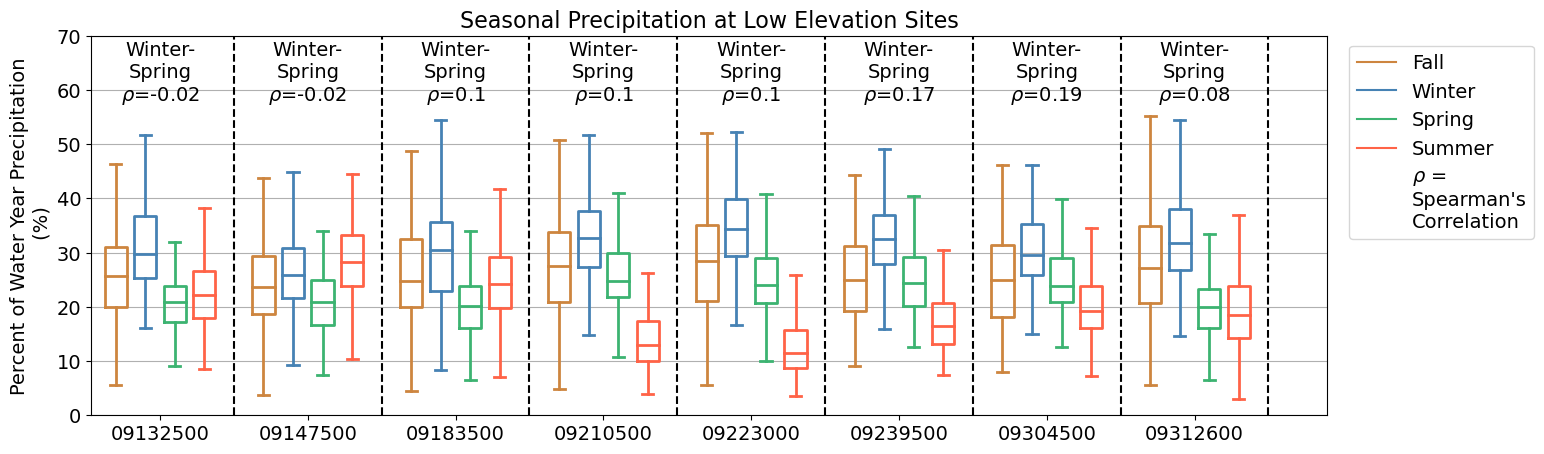

In [95]:
# create boxplot for low elevation data with a box
annual_ppt = low_elevation_annual_ppt.ppt
fall = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 10), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 1), drop=True).ppt.values.T/annual_ppt)
spring = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
summer = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 7), drop=True).ppt.values.T/annual_ppt)

ticks = low_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(15,5))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+5,len(ticks))
plt.xticks(tick_spacing, ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(low_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-\nSpring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at Low Elevation Sites', size=16)
plt.ylim(0,70)



### Look at residuals in the pre-2000 and post-2000s periods

In [119]:
def spearman_dataframe(annualq_data, ppt_data):
    # create a results dataframe
    results = pd.DataFrame(columns=['pre_springp_spearman', 'pre_winterp_spearman','post_springp_spearman', 'post_winterp_spearman', 
                                    'pre_summerp_spearman', 'pre_fallp_spearman', 'post_summerp_spearman', 'post_fallp_spearman',
                                    'pre_springp_winterp_spearman', 'post_springp_winterp_spearman'], 
                           index = ppt_data.site_no.values)
    # loop through each site
    for site in annualq_data.site_no.values:
        annualq = annualq_data.q_mm.sel(site_no=site).dropna(dim='WY')
        springp = ppt_data.where((ppt_data['month'].dt.month == 4) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        winterp = ppt_data.where((ppt_data['month'].dt.month == 1) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        summerp = ppt_data.where((ppt_data['month'].dt.month == 7) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        fallp = ppt_data.where((ppt_data['month'].dt.month == 10) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )                                            
        # split annualq into pre-2000 and post-2000
        annualq_pre = annualq.where(annualq.WY<2000,drop=True).values
        annualq_post = annualq.where(annualq.WY>=2000,drop=True).values
        # split springp into pre-2000 and post-2000
        springp_pre = springp.where(springp.month.dt.year<2000, drop=True)
        springp_post = springp.where(springp.month.dt.year>=2000, drop=True)
        # split winterp into pre-2000 and post-2000
        winterp_pre = winterp.where(winterp.month.dt.year<2000, drop=True)
        winterp_post = winterp.where(winterp.month.dt.year>=2000, drop=True)
        # split summerp into pre-2000 and post-2000
        summerp_pre = summerp.where(summerp.month.dt.year<2000, drop=True)
        summerp_post = summerp.where(summerp.month.dt.year>=2000, drop=True)
        # split fallp into pre-2000 and post-2000
        fallp_pre = fallp.where(fallp.month.dt.year<1999, drop=True)
        fallp_post = fallp.where((fallp.month.dt.year>=1999), drop=True)
        # calculate spearmans correlation for pre-2000
        pre_springp_spearman = stats.spearmanr(annualq_pre, springp_pre)
        pre_winterp_spearman = stats.spearmanr(annualq_pre, winterp_pre)
        pre_summerp_spearman = stats.spearmanr(annualq_pre, summerp_pre)
        pre_fallp_spearman = stats.spearmanr(annualq_pre, fallp_pre)
        pre_springp_winterp_spearman = stats.spearmanr(springp_pre, winterp_pre)
        # calculate spearmans correlation for post-2000
        post_springp_spearman = stats.spearmanr(annualq_post, springp_post)
        post_winterp_spearman = stats.spearmanr(annualq_post, winterp_post)
        post_summerp_spearman = stats.spearmanr(annualq_post, summerp_post)
        post_fallp_spearman = stats.spearmanr(annualq_post, fallp_post)
        post_springp_winterp_spearman = stats.spearmanr(springp_post, winterp_post)
        # store results in spearman_df
        results.loc[site] = [pre_springp_spearman[0], pre_winterp_spearman[0], post_springp_spearman[0], post_winterp_spearman[0],
                             pre_summerp_spearman[0], pre_fallp_spearman[0], post_summerp_spearman[0], post_fallp_spearman[0],
                             pre_springp_winterp_spearman[0], post_springp_winterp_spearman[0]]
    return results

In [152]:
high_spearman = spearman_dataframe(high_elevation_annual_q,high_elevation_seasonal_ppt)
mid_spearman = spearman_dataframe(mid_elevation_annual_q,mid_elevation_seasonal_ppt)
low_spearman = spearman_dataframe(low_elevation_annual_q,low_elevation_seasonal_ppt)

In [130]:
def spearman_dataframe_full(annualq_data, ppt_data):
    # create a results dataframe
    results = pd.DataFrame(columns=[ 'Winter P','Spring P',
                                    'Summer P', 'Antecedent\nFall P'], 
                           index = ppt_data.site_no.values)
    # loop through each site
    for site in annualq_data.site_no.values:
        annualq = annualq_data.q_mm.sel(site_no=site).dropna(dim='WY')
        springp = ppt_data.where((ppt_data['month'].dt.month == 4) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        winterp = ppt_data.where((ppt_data['month'].dt.month == 1) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        summerp = ppt_data.where((ppt_data['month'].dt.month == 7) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        fallp = ppt_data.where((ppt_data['month'].dt.month == 10) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        # split annualq into pre-2000 and post-2000
        annualq = annualq.where(annualq.WY>1963,drop=True).values
        # split springp into pre-2000 and post-2000
        springp = springp.where(springp.month.dt.year>1963, drop=True)
        # split winterp into pre-2000 and post-2000
        winterp = winterp.where((winterp.month.dt.year>1963), drop=True)
        # split summerp into pre-2000 and post-2000
        summerp = summerp.where(summerp.month.dt.year>1963, drop=True)
        # split fallp into pre-2000 and post-2000
        fallp = fallp.where((fallp.month.dt.year>=1963) & (fallp.month.dt.year<2022), drop=True)
        # calculate spearmans correlation for entire record
        springp_spearman = stats.spearmanr(annualq, springp)
        winterp_spearman = stats.spearmanr(annualq, winterp)
        summerp_spearman = stats.spearmanr(annualq, summerp)
        fallp_spearman = stats.spearmanr(annualq, fallp)
        springp_winterp_spearman = stats.spearmanr(springp, winterp)
        # store results in spearman_df
        results.loc[site] = [springp_spearman[0], winterp_spearman[0],
                             summerp_spearman[0], fallp_spearman[0]]
    return results

In [154]:
high_spearman = spearman_dataframe_full(high_elevation_annual_q,high_elevation_seasonal_ppt)
mid_spearman = spearman_dataframe_full(mid_elevation_annual_q,mid_elevation_seasonal_ppt)
low_spearman = spearman_dataframe_full(low_elevation_annual_q,low_elevation_seasonal_ppt)

In [140]:
# concatenate with mid_spearman
all_spearman = pd.concat([high_spearman, mid_spearman,low_spearman], axis=0)
# convert values to float
all_spearman = all_spearman.astype(float)
# get all columns that contain the word pre
pre_columns = [col for col in all_spearman.columns if 'pre' in col][:-1]
post_columns = [col for col in all_spearman.columns if 'post' in col][:-1]

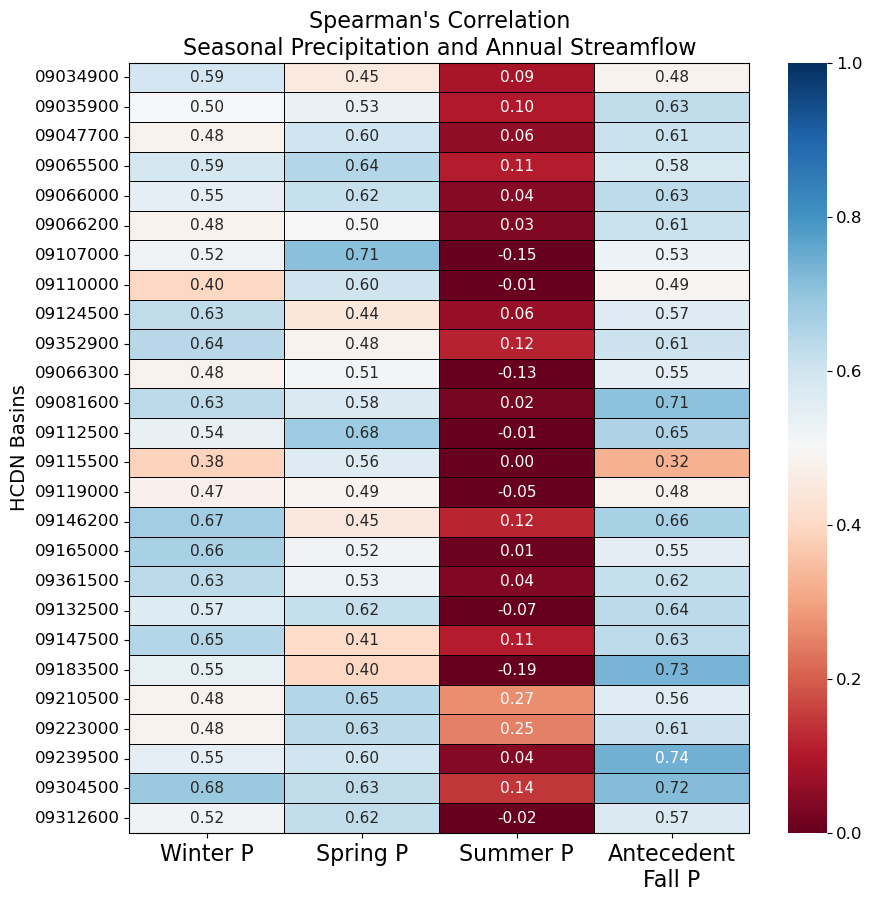

In [155]:
# concatenate with mid_spearman
all_spearman = pd.concat([high_spearman, mid_spearman,low_spearman], axis=0)
# convert values to float
all_spearman = all_spearman.astype(float)
# all_spearman_pre = all_spearman[pre_columns]
# # rename columns to be "Winter P", "Spring P", "Summer P", "Antecedent Fall P"
# all_spearman_pre = all_spearman_pre.rename(columns=dict(zip(all_spearman_pre.columns,["Winter P", "Spring P", "Summer P", "Antecedent Fall\nP"])))

# all_spearman_post = all_spearman[post_columns]
# # rename columns to be "Winter Q", "Spring Q", "Summer Q", "Antecedent Fall Q"
# all_spearman_post = all_spearman_post.rename(columns=dict(zip(all_spearman_post.columns,["Winter P", "Spring P", "Summer P", "Antecedent Fall\nP"])))

# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(all_spearman, vmin=0, vmax=1, cmap='RdBu', annot=True, fmt='.2f', annot_kws={"size": 11}, linecolor='k', linewidths=0.5, ax=ax)
# add title "Seasonal Precipitation Spearman's Correlation to Annual Streamflow"
ax.set_title("Spearman's Correlation\nSeasonal Precipitation and Annual Streamflow", fontsize=16)
# increase font size of tick lables
ax.tick_params(labelsize=12)
# increase font size of x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
ax.set_ylabel("HCDN Basins", fontsize=14)
# increase the font size of the colorbar labels
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# add frame around plot
for _, spine in ax.spines.items():
    spine.set_visible(True)
    




ranksum_pvalue ttest_pvalue
09132500       0.000001          0.0
09147500            0.0          0.0
09183500       0.002579     0.001031
09210500       0.000094     0.000072
09223000       0.000073      0.00003
09239500       0.000067     0.000025
09304500        0.00001     0.000006
09312600       0.001898     0.001055

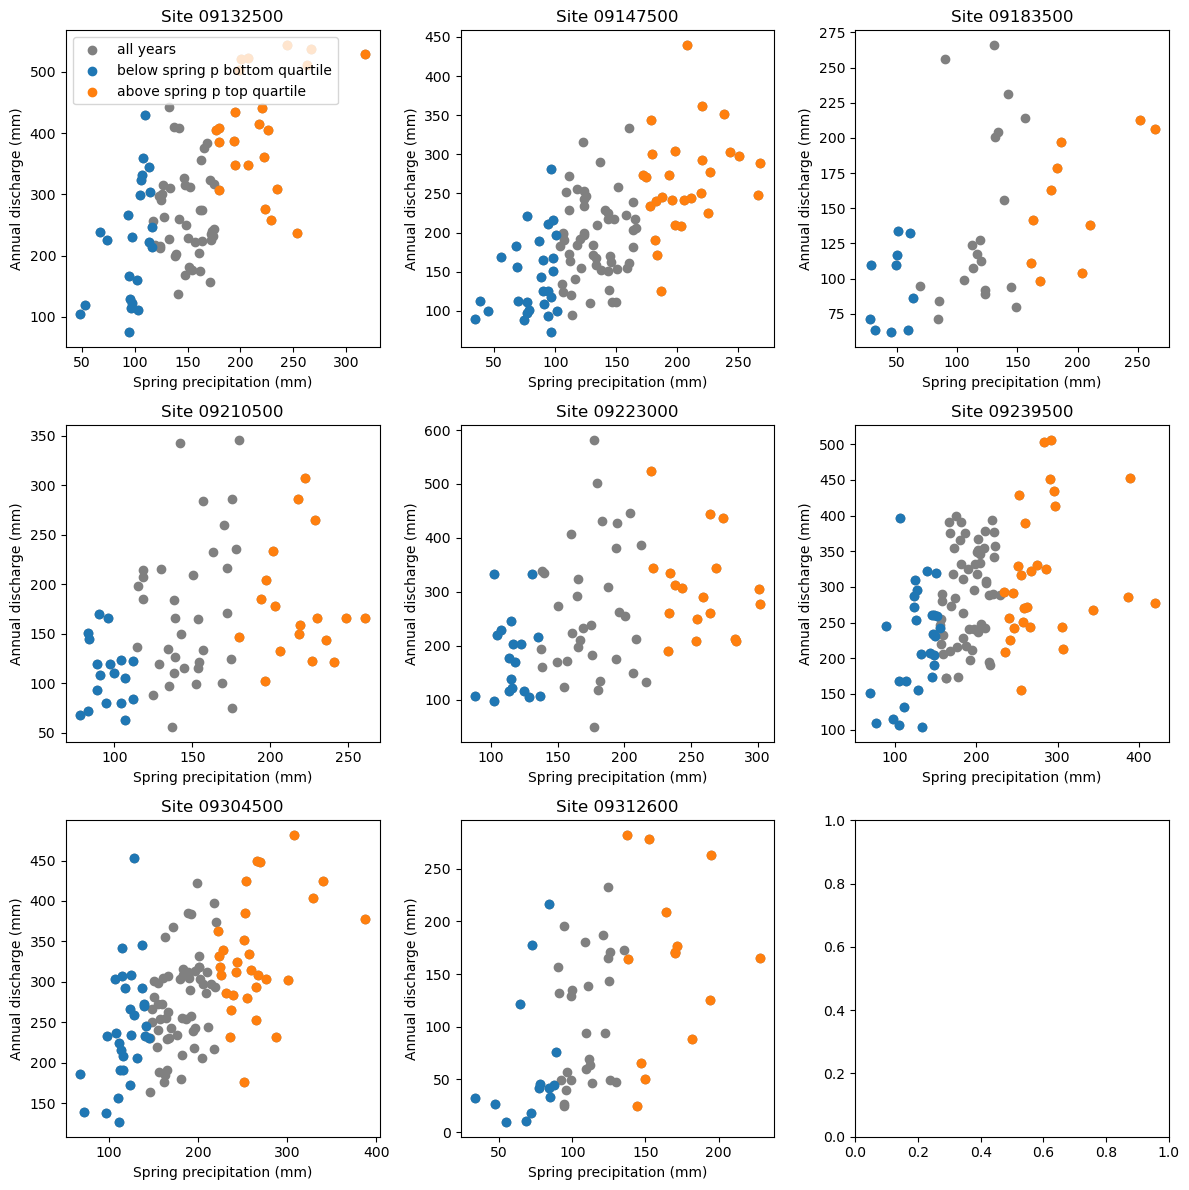

In [157]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to low_elevation_annual_q.site_no
low_elevation_ttest = pd.DataFrame(index=low_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(3,3, figsize=(12,12), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(low_elevation_annual_q.site_no.values):
    tmp = low_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = low_elevation_seasonal_ppt.sel(site_no=site).where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    # tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.year), drop=True).ppt.to_pandas()
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_mm, tmp_df_above.q_mm, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='less')
    ranksum_test = stats.ranksums(tmp_df_below.q_mm, tmp_df_above.q_mm,
                                  nan_policy='omit',
                                  alternative='less')
    low_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    low_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='grey')
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')              

low_elevation_ttest

In [446]:
# # create a slope chart for winter and spring periods
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True, tight_layout=True)
# axs = axs.ravel()
# # make a colorblind color palette with the same length as high_spearman.index
# colors = sns.color_palette("colorblind", len(high_spearman.index))
# # plot the winter pre and post data
# for i,site in enumerate(high_spearman.index):
#     temp = high_spearman.loc[site]
#     axs[0].plot([2000,2022], [temp.pre_winterp_spearman, temp.post_winterp_spearman], color=colors[i], marker='o', markersize=5, label=site)
#     # # add labels to the lines
#     # axs[0].annotate(site, xy=(2022, temp.post_winterp_spearman), xytext=(2022+0.4, temp.post_winterp_spearman),ha='left', va='center', fontsize=10)
#     # axs[0].annotate(site, xy=(2000, temp.pre_winterp_spearman), xytext=(2000-0.4, temp.pre_winterp_spearman),ha='right', va='center', fontsize=10)
    
# # change the xlabels to be "1964-1999" and "2000-2022"
# axs[0].set_xticks([1995,2000,2022,2027])
# axs[0].set_xticklabels(['','1964-1999', '2000-2022',''])
# # set title
# axs[0].set_title('Winter', fontsize=14)

# # plot the spring pre and post data
# for i,site in enumerate(high_spearman.index):
#     temp = high_spearman.loc[site]
#     axs[1].plot([2000,2022], [temp.pre_springp_spearman, temp.post_springp_spearman], color=colors[i], marker='o', markersize=5, label=site)
#     # # add labels to the lines
#     # axs[1].annotate(site, xy=(2000, temp.pre_springp_spearman), xytext=(2000-0.4, temp.pre_springp_spearman), fontsize=10,ha='right', va='center')
#     # axs[1].annotate(site, xy=(2022, temp.post_springp_spearman), xytext=(2022+0.4, temp.post_springp_spearman), fontsize=10,ha='left', va='center')
# # mplcursors.cursor(multiple=True).connect(
# #     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# # change the xlabels to be "1964-1999" and "2000-2022"
# axs[1].set_xticks([1995,2000,2022,2027])
# axs[1].set_xticklabels(['','1964-1999', '2000-2022',''])
# # set title
# axs[1].set_title('Spring', fontsize=14)

# # add legend outside the plot
# axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Gage ID')
# # plot the summerp pre and post data
# for i,site in enumerate(high_spearman.index):
#     temp = high_spearman.loc[site]
#     axs[2].plot([2000,2022], [temp.pre_summerp_spearman, temp.post_summerp_spearman], color=colors[i], marker='o', markersize=5, label=site)
#     # # add labels to the lines
#     # axs[2].annotate(site, xy=(2000, temp.pre_summerp_spearman), xytext=(2000-0.4, temp.pre_summerp_spearman), fontsize=10,ha='right', va='center')
#     # axs[2].annotate(site, xy=(2022, temp.post_summerp_spearman), xytext=(2022+0.4, temp.post_summerp_spearman), fontsize=10,ha='left', va='center')
# # mplcursors.cursor(multiple=True).connect(
# #     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# # change the xlabels to be "1964-1999" and "2000-2022"
# axs[2].set_xticks([1995,2000,2022,2027])
# axs[2].set_xticklabels(['','1964-1999', '2000-2022',''])
# # set title
# axs[2].set_title('Summer', fontsize=14)


# # plot the fallp pre and post data
# for i,site in enumerate(high_spearman.index):
#     temp = high_spearman.loc[site]
#     axs[3].plot([2000,2022], [temp.pre_fallp_spearman, temp.post_fallp_spearman], color=colors[i], marker='o', markersize=5, label=site)
#     # # add labels to the lines
#     # axs[3].annotate(site, xy=(2000, temp.pre_fallp_spearman), xytext=(2000-0.4, temp.pre_fallp_spearman), fontsize=10,ha='right', va='center')
#     # axs[3].annotate(site, xy=(2022, temp.post_fallp_spearman), xytext=(2022+0.4, temp.post_fallp_spearman), fontsize=10,ha='left', va='center')
# # mplcursors.cursor(multiple=True).connect(
# #     "add", lambda sel:sel.annotation.set_text(sel.artist.get_label()))
# # change the xlabels to be "1964-1999" and "2000-2022"
# axs[3].set_xticks([1995,2000,2022,2027])
# axs[3].set_xticklabels(['','1964-1999', '2000-2022',''])
# # set title
# axs[3].set_title('Fall', fontsize=14)

# fig.suptitle('Seasonal Precipitation & Annual Streamflow Spearman Correlation\nHigh Elevation Basins',size=14)
# # add y-grid lines in gray to all plots
# for ax in axs:
#     ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
# fig.suptitle('Seasonal Precipitation & Annual Streamflow Spearman Correlation\nHigh Elevation Basins',size=14)
# # create a common Y label
# fig.text(-0.02,0.5, 'Spearman Correlation', va='center', rotation='vertical', fontsize=14)

### Hypothesis testing for change in the amount of annual precipitation in pre- and post-2000 periods

1) High Elevation Basins

In [158]:
high_annualp_ttest_results = pd.DataFrame(index=high_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_ppt.site_no.values:
    minyear = high_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [159]:
high_annualp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900        0.442516                                  Probably Gaussian   
09035900        0.636219                                  Probably Gaussian   
09047700        0.277287                                  Probably Gaussian   
09065500        0.458158                                  Probably Gaussian   
09066000        0.457203                                  Probably Gaussian   
09066200        0.376326                                  Probably Gaussian   
09107000        0.223627                                  Probably Gaussian   
09110000        0.223627                                  Probably Gaussian   
09124500         0.09449  Probably not Gaussian, consider a non-parametr...   
09352900        0.499938                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900    0.408  Null Hypothesis Accepted           NaN   
09035900    0.487  Null Hypothesis Accepted           NaN   
09047700    0.812  Null Hypothesis Accepted           NaN   
09065500    0.407  Null Hypothesis Accepted           NaN   
09066000    0.401  Null Hypothesis Accepted           NaN   
09066200    0.658  Null Hypothesis Accepted           NaN   
09107000    0.029  Null Hypothesis Rejected           NaN   
09110000    0.029  Null Hypothesis Rejected           NaN   
09124500      NaN                       NaN         0.957   
09352900    0.003  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference  
09034900                       NaN          -0.93            -7.13  
09035900                       NaN          -0.13            -0.94  
09047700                       NaN           3.78            18.84  
09065500                       NaN          -1.03            -8.23  
09066000                       NaN           -1.1            -8.85  
09066200                       NaN           1.75            12.54  
09107000                       NaN           -7.7           -53.22  
09110000                       NaN           -7.7           -53.22  
09124500  Null Hypothesis Accepted         -10.56           -80.95  
09352900                       NaN         -13.39          -129.69

2) Mid Elevation Basins

In [161]:
mid_annualp_ttest_results = pd.DataFrame(index=mid_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_ppt.site_no.values:
    minyear = mid_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    mid_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    mid_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [162]:
mid_annualp_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300        0.165788                                  Probably Gaussian   
09081600        0.937484                                  Probably Gaussian   
09112500        0.374255                                  Probably Gaussian   
09115500        0.870051                                  Probably Gaussian   
09119000        0.711757                                  Probably Gaussian   
09146200        0.275587                                  Probably Gaussian   
09165000        0.094848  Probably not Gaussian, consider a non-parametr...   
09361500        0.143932                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300    0.827  Null Hypothesis Accepted           NaN   
09081600    0.006  Null Hypothesis Rejected           NaN   
09112500    0.001  Null Hypothesis Rejected           NaN   
09115500    0.007  Null Hypothesis Rejected           NaN   
09119000    0.002  Null Hypothesis Rejected           NaN   
09146200     0.01  Null Hypothesis Rejected           NaN   
09165000      NaN                       NaN         0.985   
09361500    0.003  Null Hypothesis Rejected           NaN   

                mannwhitney Result percent change value difference  
09066300                       NaN           3.99             23.0  
09081600                       NaN         -10.86          -111.42  
09112500                       NaN         -12.82          -120.11  
09115500                       NaN          -9.88           -62.87  
09119000                       NaN          -10.5            -53.7  
09146200                       NaN          -9.81           -74.73  
09165000  Null Hypothesis Accepted         -12.82          -107.39  
09361500                       NaN         -12.81          -117.08

3) Low Elevation Basins

In [163]:
low_annualp_ttest_results = pd.DataFrame(index=low_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_ppt.site_no.values:
    minyear = low_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    low_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    low_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [164]:
low_annualp_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p  \
09132500        0.574237    Probably Gaussian    0.028   
09147500        0.315093    Probably Gaussian    0.008   
09183500        0.956135    Probably Gaussian    0.005   
09210500        0.354881    Probably Gaussian    0.041   
09223000        0.433027    Probably Gaussian    0.056   
09239500        0.827164    Probably Gaussian    0.022   
09304500        0.466386    Probably Gaussian    0.001   
09312600        0.683787    Probably Gaussian    0.122   

                     t-test Result mannwhitney p mannwhitney Result  \
09132500  Null Hypothesis Rejected           NaN                NaN   
09147500  Null Hypothesis Rejected           NaN                NaN   
09183500  Null Hypothesis Rejected           NaN                NaN   
09210500  Null Hypothesis Rejected           NaN                NaN   
09223000  Null Hypothesis Rejected           NaN                NaN   
09239500  Null Hypothesis Rejected           NaN                NaN   
09304500  Null Hypothesis Rejected           NaN                NaN   
09312600  Null Hypothesis Accepted           NaN                NaN   

         percent change value difference  
09132500          -8.14           -62.09  
09147500          -9.93           -68.22  
09183500         -13.21           -90.65  
09210500          -9.23           -56.44  
09223000          -8.38           -62.91  
09239500          -8.54           -70.61  
09304500         -13.59          -111.78  
09312600           -6.1           -34.61

4. Upper Colorado River Basin

In [165]:
ucrb_annual_ppt = ucrb_ppt_seasonal_mean.groupby('WY').sum()
ucrb_annual_ppt_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p'
                                                                                    ])
single_site_pre = np.log(ucrb_annual_ppt['ppt'].to_pandas().loc[1966:1999])
single_site_post = np.log(ucrb_annual_ppt['ppt'].to_pandas().loc[2000:])
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_annual_ppt_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [166]:
ucrb_annual_ppt_ttest_results

Shapiro-Wilke p Shapiro-Wilke Result t-test p             t-test Result  \
UCRB        0.696742    Probably Gaussian    0.029  Null Hypothesis Rejected   

     mannwhitney p  
UCRB           NaN

Annual Precipitation Shift Plots

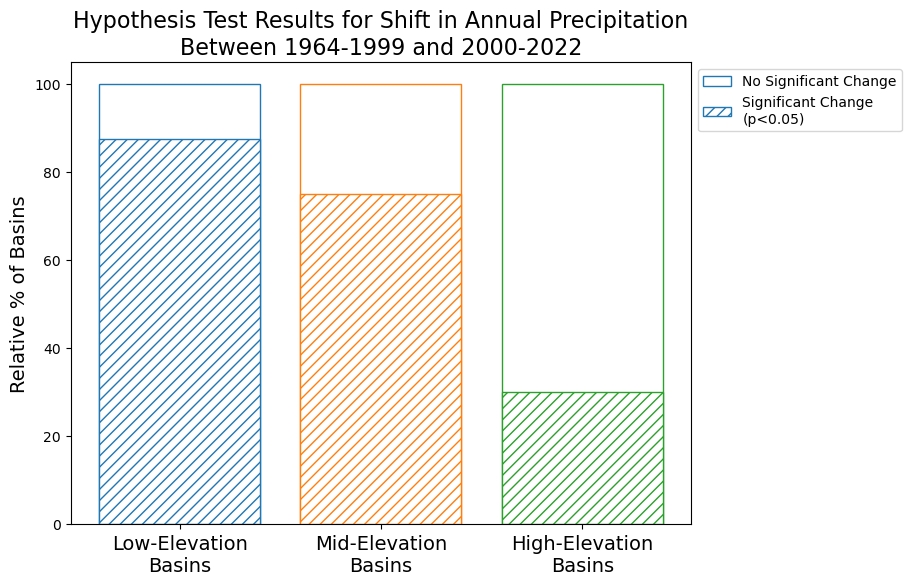

In [167]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)

(0.0, 13.0)

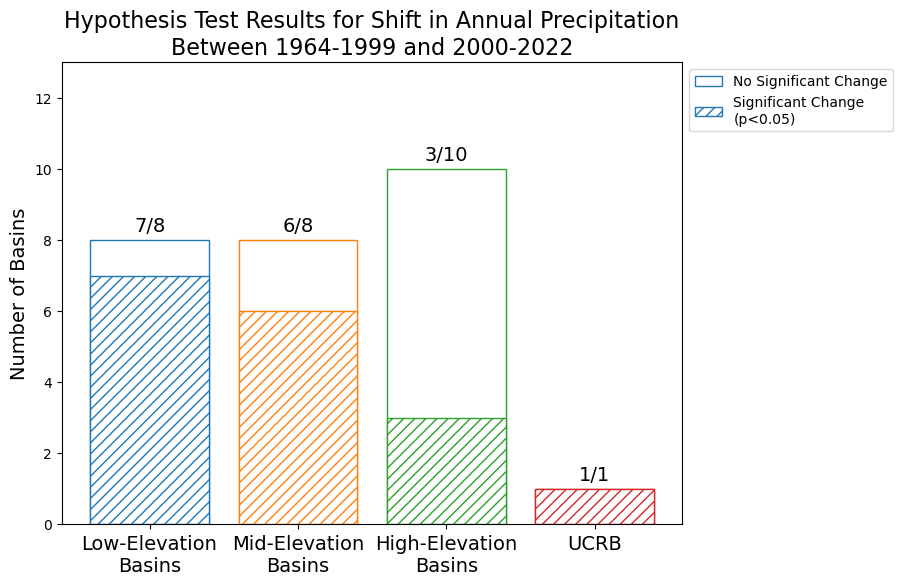

In [168]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
ucrb_rejected = len(ucrb_annual_ppt_ttest_results[(ucrb_annual_ppt_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_annual_ppt_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

ranksum_pvalue ttest_pvalue
09034900       0.000013     0.000001
09035900       0.000026     0.000002
09047700       0.000011          0.0
09065500       0.000002          0.0
09066000       0.000003          0.0
09066200       0.000009     0.000002
09107000       0.000079     0.000014
09110000            0.0          0.0
09124500            0.0          0.0
09352900       0.000002     0.006026

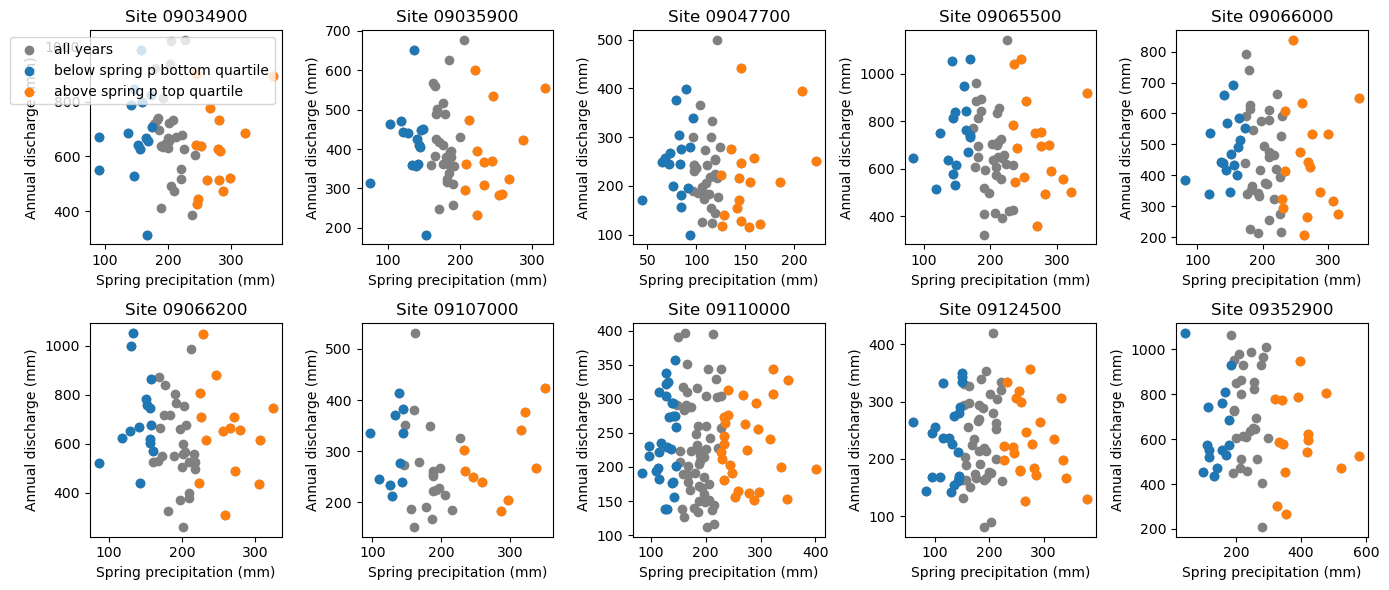

In [177]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to high_elevation_annual_q.site_no
high_elevation_ttest = pd.DataFrame(index=high_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(2,5, figsize=(14,6), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(high_elevation_annual_q.site_no.values):
    tmp = high_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = high_elevation_seasonal_ppt.sel(site_no=site).where(high_elevation_seasonal_ppt.month.dt.month==1, drop=True)
    tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.WY), drop=True).ppt.to_pandas()
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.year), drop=True).ppt.to_pandas()
    # tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_ppt_ratio, tmp_df_above.q_ppt_ratio, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='greater')
    ranksum_test = stats.ranksums(tmp_df_below.q_ppt_ratio, tmp_df_above.q_ppt_ratio,
                                  nan_policy='omit',
                                  alternative='greater')
    high_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    high_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='grey')
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')                       
high_elevation_ttest

ranksum_pvalue ttest_pvalue
09066300       0.000074     0.000007
09081600       0.000002          0.0
09112500            0.0          0.0
09115500       0.000013     0.000005
09119000       0.000065     0.000026
09146200       0.000006     0.000032
09165000       0.000002     0.005526
09361500            0.0     0.000288

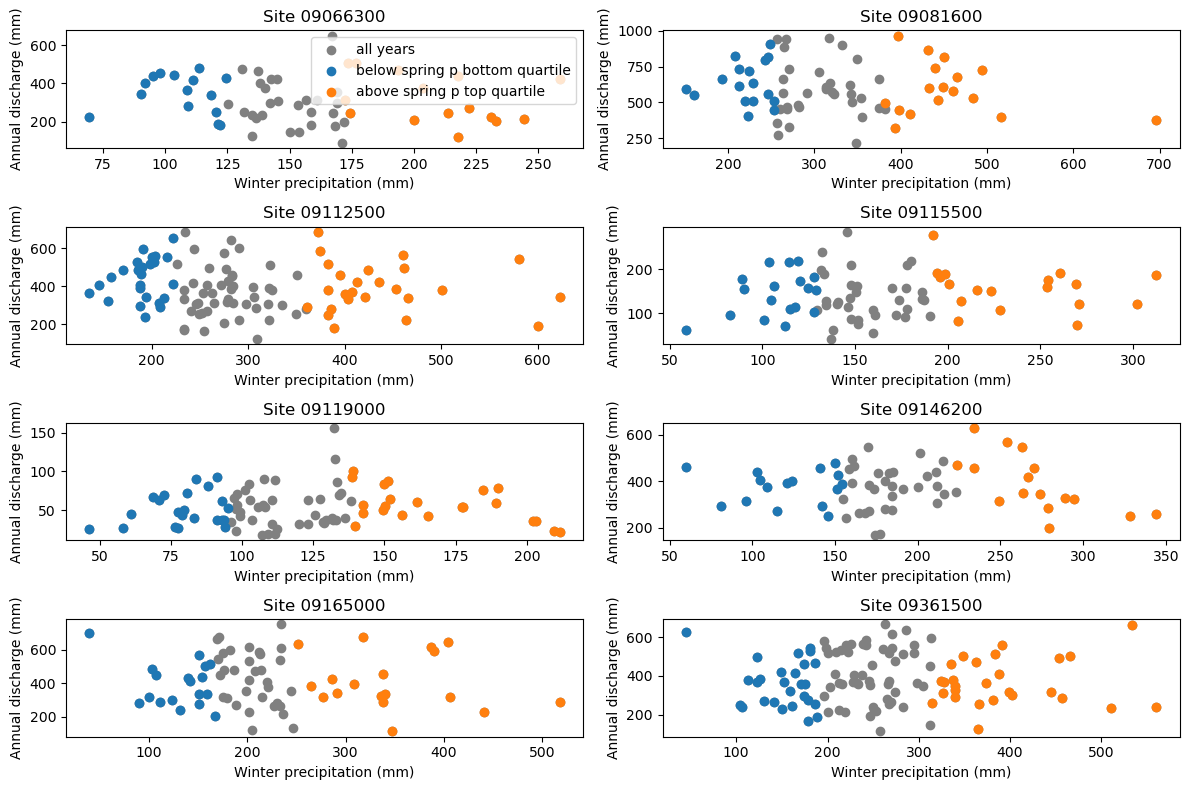

In [179]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to mid_elevation_annual_q.site_no
mid_elevation_ttest = pd.DataFrame(index=mid_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(4,2, figsize=(12,8), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(mid_elevation_annual_q.site_no.values):
    tmp = mid_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = mid_elevation_seasonal_ppt.sel(site_no=site).where(mid_elevation_seasonal_ppt.month.dt.month==1, drop=True)
    tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.WY), drop=True).ppt.to_pandas()
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.year), drop=True).ppt.to_pandas()
    # tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_ppt_ratio, tmp_df_above.q_ppt_ratio, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='greater')
    ranksum_test = stats.ranksums(tmp_df_below.q_ppt_ratio, tmp_df_above.q_ppt_ratio,
                                  nan_policy='omit',
                                  alternative='greater')
    mid_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    mid_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='grey')
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Winter precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')                       
mid_elevation_ttest

ranksum_pvalue ttest_pvalue
09132500       0.000001          0.0
09147500            0.0     0.000005
09183500       0.000335     0.000193
09210500       0.000083     0.000076
09223000       0.000155     0.000092
09239500            0.0          0.0
09304500            0.0          0.0
09312600       0.000553     0.000188

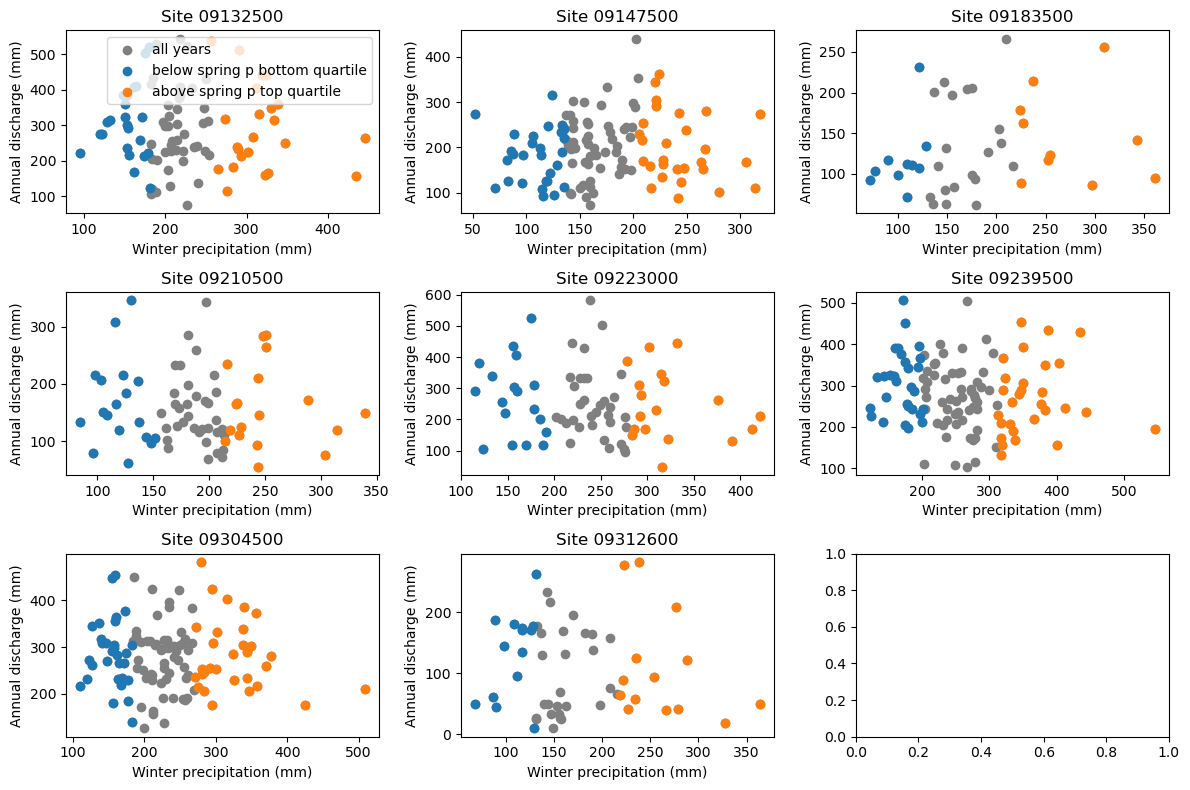

In [180]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to low_elevation_annual_q.site_no
low_elevation_ttest = pd.DataFrame(index=low_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(3,3, figsize=(12,8), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(low_elevation_annual_q.site_no.values):
    tmp = low_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = low_elevation_seasonal_ppt.sel(site_no=site).where(low_elevation_seasonal_ppt.month.dt.month==1, drop=True)
    tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.WY), drop=True).ppt.to_pandas()
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.year), drop=True).ppt.to_pandas()
    # tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_ppt_ratio, tmp_df_above.q_ppt_ratio, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='greater')
    ranksum_test = stats.ranksums(tmp_df_below.q_ppt_ratio, tmp_df_above.q_ppt_ratio,
                                  nan_policy='omit',
                                  alternative='greater')
    low_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    low_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='grey')
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Winter precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')                       
low_elevation_ttest

# Spring changes

ranksum_pvalue ttest_pvalue
09034900       0.000053     0.000026
09035900       0.000754     0.000231
09047700       0.001615     0.000695
09065500       0.000071     0.000024
09066000       0.000107     0.000019
09066200       0.001319     0.000389
09107000       0.004075     0.003049
09110000       0.008749     0.004164
09124500            0.0          0.0
09352900       0.000062     0.000006

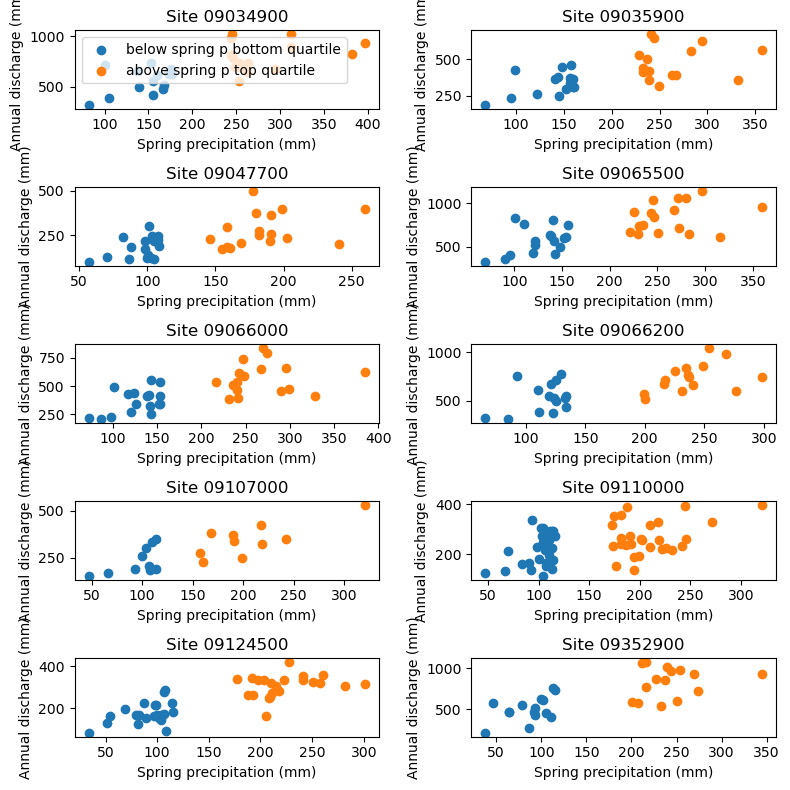

In [183]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to high_elevation_annual_q.site_no
high_elevation_ttest = pd.DataFrame(index=high_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(8,8), tight_layout=True)
axs = axs.ravel()
for i,site in enumerate(high_elevation_annual_q.site_no.values):
    tmp = high_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = high_elevation_seasonal_ppt.sel(site_no=site).where(high_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    # tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.year), drop=True).ppt.to_pandas()
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_mm, tmp_df_above.q_mm, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='less')
    ranksum_test = stats.ranksums(tmp_df_below.q_mm, tmp_df_above.q_mm,
                                  nan_policy='omit',
                                  alternative='less')
    high_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    high_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')
high_elevation_ttest


ranksum_pvalue ttest_pvalue
09066300       0.000488     0.000112
09081600       0.000026     0.000001
09112500       0.000003     0.000001
09115500         0.0005     0.000285
09119000       0.000072     0.000046
09146200       0.000003          0.0
09165000       0.000013     0.000002
09361500            0.0          0.0

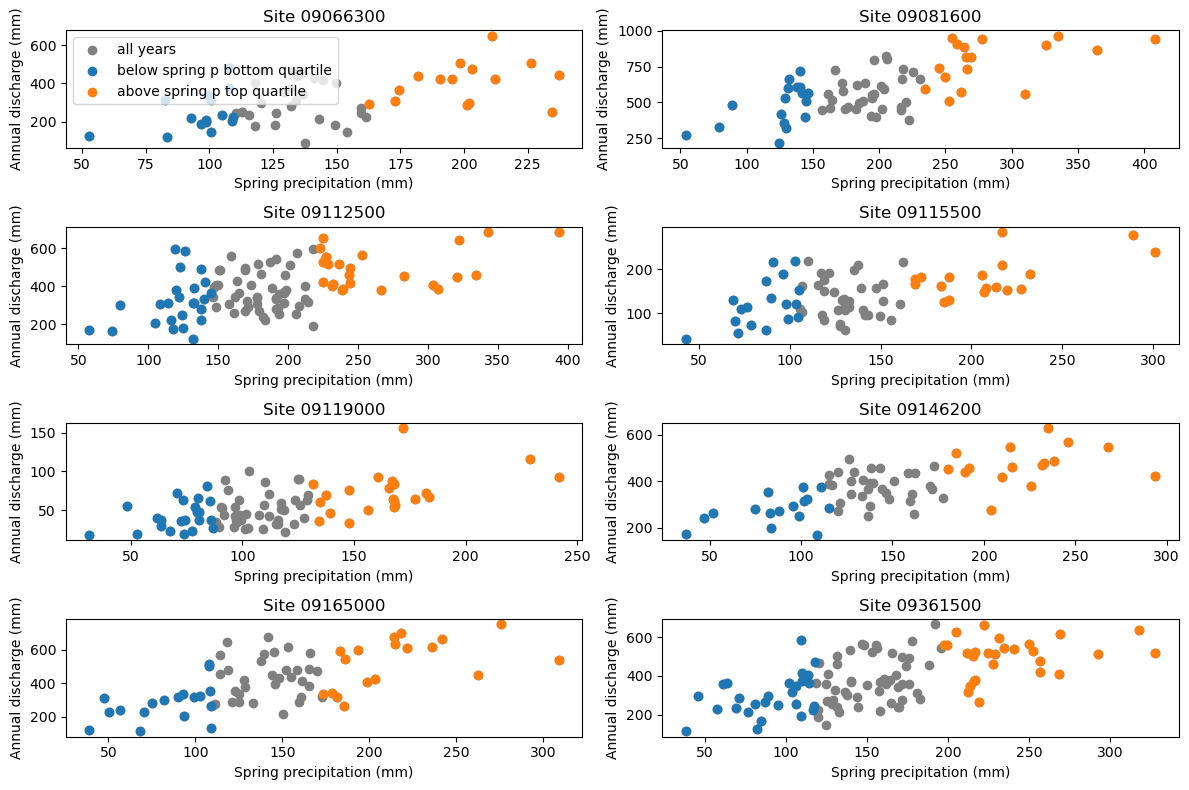

In [185]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to mid_elevation_annual_q.site_no
mid_elevation_ttest = pd.DataFrame(index=mid_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])

fig, axs = plt.subplots(4,2, figsize=(12,8), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(mid_elevation_annual_q.site_no.values):
    tmp = mid_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = mid_elevation_seasonal_ppt.sel(site_no=site).where(mid_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    # tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.year), drop=True).ppt.to_pandas()
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_mm, tmp_df_above.q_mm, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='less')
    ranksum_test = stats.ranksums(tmp_df_below.q_mm, tmp_df_above.q_mm,
                                  nan_policy='omit',
                                  alternative='less')
    mid_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    mid_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='grey')
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')              

mid_elevation_ttest

ranksum_pvalue ttest_pvalue
09132500       0.000001          0.0
09147500            0.0          0.0
09183500       0.002579     0.001031
09210500       0.000094     0.000072
09223000       0.000073      0.00003
09239500       0.000067     0.000025
09304500        0.00001     0.000006
09312600       0.001898     0.001055

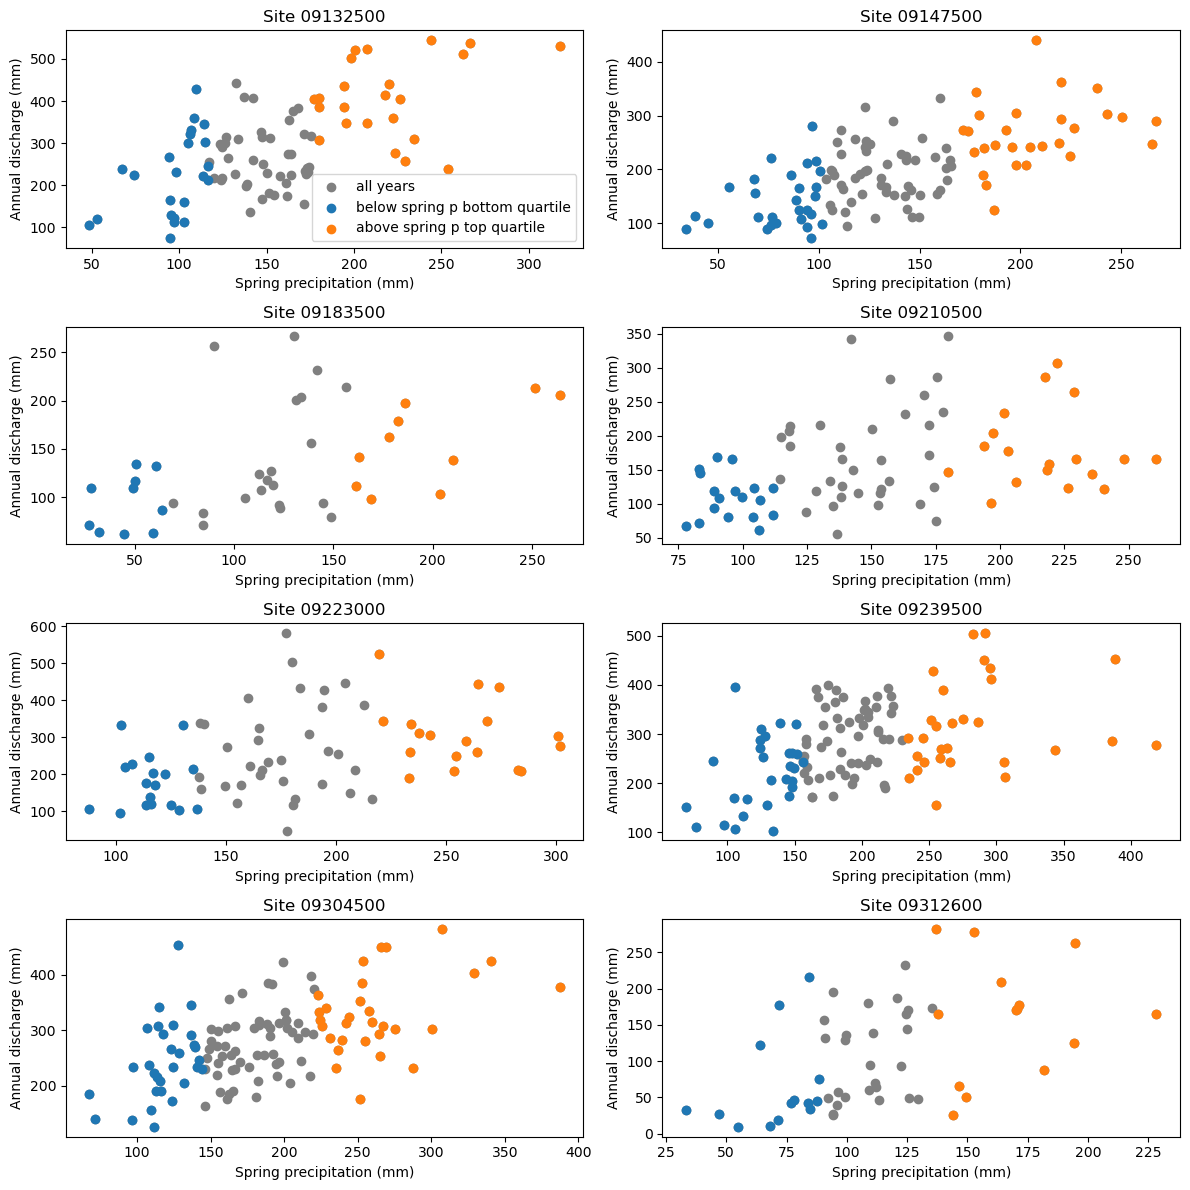

In [186]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to low_elevation_annual_q.site_no
low_elevation_ttest = pd.DataFrame(index=low_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(4,2, figsize=(12,12), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(low_elevation_annual_q.site_no.values):
    tmp = low_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    tmp_ppt = low_elevation_seasonal_ppt.sel(site_no=site).where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    # tmp_ppt['month'] = tmp_ppt.month.dt.year+1
    # tmp_ppt = tmp_ppt.where(tmp_ppt.month.isin(tmp.year), drop=True).ppt.to_pandas()
    tmp_ppt = tmp_ppt.where(tmp_ppt.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt.index = tmp_ppt.index.year
    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm']
    # add a new column for the ratio of q_mm to ppt_mm
    tmp_df['q_ppt_ratio'] = tmp_df.q_mm/tmp_df.ppt_mm
    # SORT BY ppt
    tmp_df = tmp_df.sort_values(by='ppt_mm').dropna()
    # below 25th percentile
    tmp_df_below = tmp_df[tmp_df.ppt_mm<=np.percentile(tmp_df.ppt_mm,25)]
    # above 75th percentile
    tmp_df_above = tmp_df[tmp_df.ppt_mm>=np.percentile(tmp_df.ppt_mm,75)]
    # ttest to compare q_mm between above and below mean
    ttest = stats.ttest_ind(tmp_df_below.q_mm, tmp_df_above.q_mm, 
                            equal_var=False, 
                            nan_policy='omit',
                            alternative='less')
    ranksum_test = stats.ranksums(tmp_df_below.q_mm, tmp_df_above.q_mm,
                                  nan_policy='omit',
                                  alternative='less')
    low_elevation_ttest.loc[site, 'ranksum_pvalue'] = ranksum_test.pvalue                               
    low_elevation_ttest.loc[site, 'ttest_pvalue'] = ttest.pvalue  
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='grey')
    ax.scatter(tmp_df_below.ppt_mm, tmp_df_below.q_mm, label='below spring p bottom quartile')
    ax.scatter(tmp_df_above.ppt_mm,tmp_df_above.q_mm, label='above spring p top quartile')                           
    if i == 0:
        ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')              

low_elevation_ttest

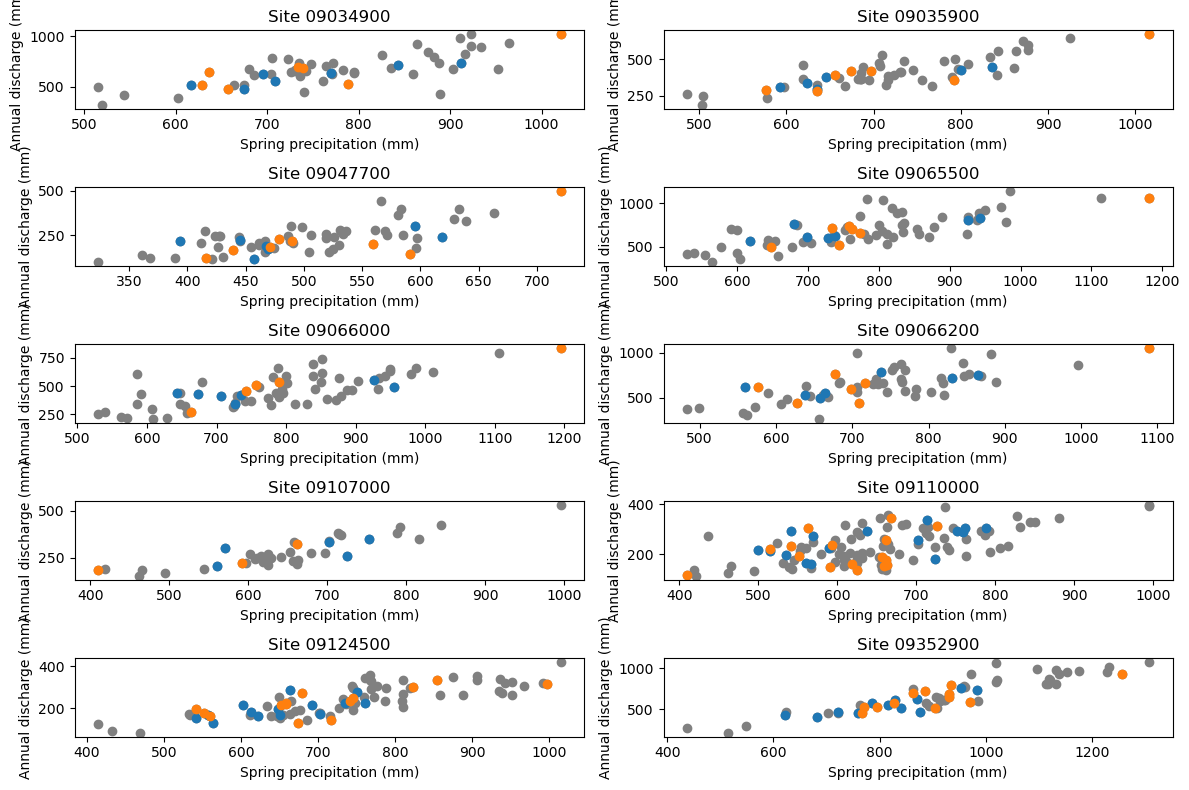

In [191]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to high_elevation_annual_q.site_no
high_elevation_ttest = pd.DataFrame(index=high_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(5,2, figsize=(12,8), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(high_elevation_annual_q.site_no.values):
    tmp = high_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    # annual ppt
    tmp_ppt_annual = high_elevation_annual_ppt.sel(site_no=site)
    tmp_ppt_annual = tmp_ppt_annual.where(tmp_ppt_annual.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    # spring ppt
    tmp_ppt_spring = high_elevation_seasonal_ppt.sel(site_no=site).where(high_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    tmp_ppt_spring = tmp_ppt_spring.where(tmp_ppt_spring.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt_spring.index = tmp_ppt_spring.index.year
    # winter ppt
    tmp_ppt_winter = high_elevation_seasonal_ppt.sel(site_no=site).where(high_elevation_seasonal_ppt.month.dt.month==1, drop=True)
    tmp_ppt_winter = tmp_ppt_winter.where(tmp_ppt_winter.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt_winter.index = tmp_ppt_winter.index.year

    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt_annual, tmp_ppt_spring, tmp_ppt_winter], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm', 'spring_ppt_mm', 'winter_ppt_mm']
    # create a ratio of spring ppt and annual ppt
    tmp_df['spring_ppt_ratio'] = tmp_df['spring_ppt_mm'] / tmp_df['ppt_mm']
    # create a ratio of winter ppt and annual ppt
    tmp_df['winter_ppt_ratio'] = tmp_df['winter_ppt_mm'] / tmp_df['ppt_mm']
    # grab the lowest quartile of ppt_mm
    ppt_mm_q1 = tmp_df['ppt_mm'].quantile(1)
    # grab years when spring ppt is in the lowest quartile and winter ppt is above average

    tmp_low_quartile = tmp_df[(tmp_df['spring_ppt_mm']<=tmp_df['spring_ppt_mm'].quantile(0.25)) & (tmp_df['winter_ppt_mm']>tmp_df['winter_ppt_mm'].quantile(0.35))]
    tmp_high_quartile = tmp_df[(tmp_df['winter_ppt_mm']<=tmp_df['winter_ppt_mm'].quantile(0.25)) & (tmp_df['spring_ppt_mm']>tmp_df['spring_ppt_mm'].quantile(0.35))]
    
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='gray')
    ax.scatter(tmp_low_quartile.ppt_mm,tmp_low_quartile.q_mm, label='years with below avg spring ppt and\nhigher than average winter ppt')
    ax.scatter(tmp_high_quartile.ppt_mm,tmp_high_quartile.q_mm, label='years with below avg winter ppt and\nhigher than average spring ppt')                           

    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')    
# turn off the spines on the last axis

# create a dummy legend box
# axs[-1].scatter([],[], label='years with lowest quartile of spring ppt and\nhigher than average winter ppt')
# axs[-1].scatter([],[], label='years with lowest quartile of winter ppt and\nhigher than average spring ppt')                           

# axs[-1].legend()
# axs[-1].axis('off')
           

In [195]:
tmp_ppt_winter

Series([], dtype: float64)

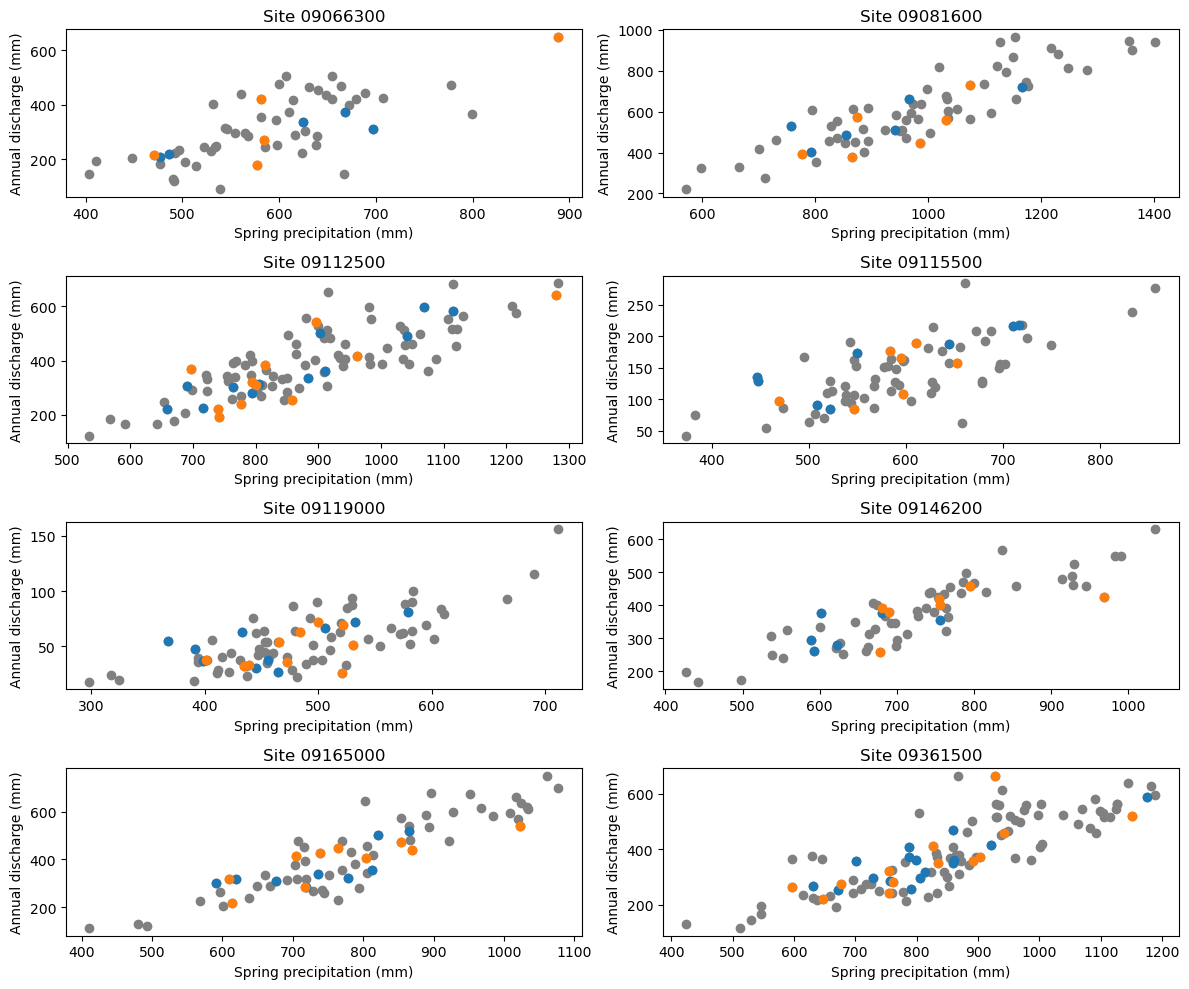

In [197]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to mid_elevation_annual_q.site_no
mid_elevation_ttest = pd.DataFrame(index=mid_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(4,2, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(mid_elevation_annual_q.site_no.values):
    tmp = mid_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    # annual ppt
    tmp_ppt_annual = mid_elevation_annual_ppt.sel(site_no=site)
    tmp_ppt_annual = tmp_ppt_annual.where(tmp_ppt_annual.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    # spring ppt
    tmp_ppt_spring = mid_elevation_seasonal_ppt.sel(site_no=site).where(mid_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    tmp_ppt_spring = tmp_ppt_spring.where(tmp_ppt_spring.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt_spring.index = tmp_ppt_spring.index.year
    # winter ppt
    tmp_ppt_winter = mid_elevation_seasonal_ppt.sel(site_no=site).where(mid_elevation_seasonal_ppt.month.dt.month==1, drop=True)
    tmp_ppt_winter = tmp_ppt_winter.where(tmp_ppt_winter.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt_winter.index = tmp_ppt_winter.index.year

    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt_annual, tmp_ppt_spring, tmp_ppt_winter], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm', 'spring_ppt_mm', 'winter_ppt_mm']
    # create a ratio of spring ppt and annual ppt
    tmp_df['spring_ppt_ratio'] = tmp_df['spring_ppt_mm'] / tmp_df['ppt_mm']
    # create a ratio of winter ppt and annual ppt
    tmp_df['winter_ppt_ratio'] = tmp_df['winter_ppt_mm'] / tmp_df['ppt_mm']
    # grab the lowest quartile of ppt_mm
    ppt_mm_q1 = tmp_df['ppt_mm'].quantile(1)
    # grab years when spring ppt is in the lowest quartile and winter ppt is above average

    tmp_mid_quartile = tmp_df[(tmp_df['spring_ppt_mm']<=tmp_df['spring_ppt_mm'].quantile(0.25)) & (tmp_df['winter_ppt_mm']>tmp_df['winter_ppt_mm'].quantile(0.5))]
    tmp_high_quartile = tmp_df[(tmp_df['winter_ppt_mm']<=tmp_df['winter_ppt_mm'].quantile(0.25)) & (tmp_df['spring_ppt_mm']>tmp_df['spring_ppt_mm'].quantile(0.5))]
    
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='gray')
    ax.scatter(tmp_mid_quartile.ppt_mm,tmp_mid_quartile.q_mm, label='years with lowest quartile of spring ppt and\nhigher than average winter ppt')
    ax.scatter(tmp_high_quartile.ppt_mm,tmp_high_quartile.q_mm, label='years with lowest quartile of winter ppt and\nhigher than average spring ppt')                           
    # if i==0:
        # ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')              
           

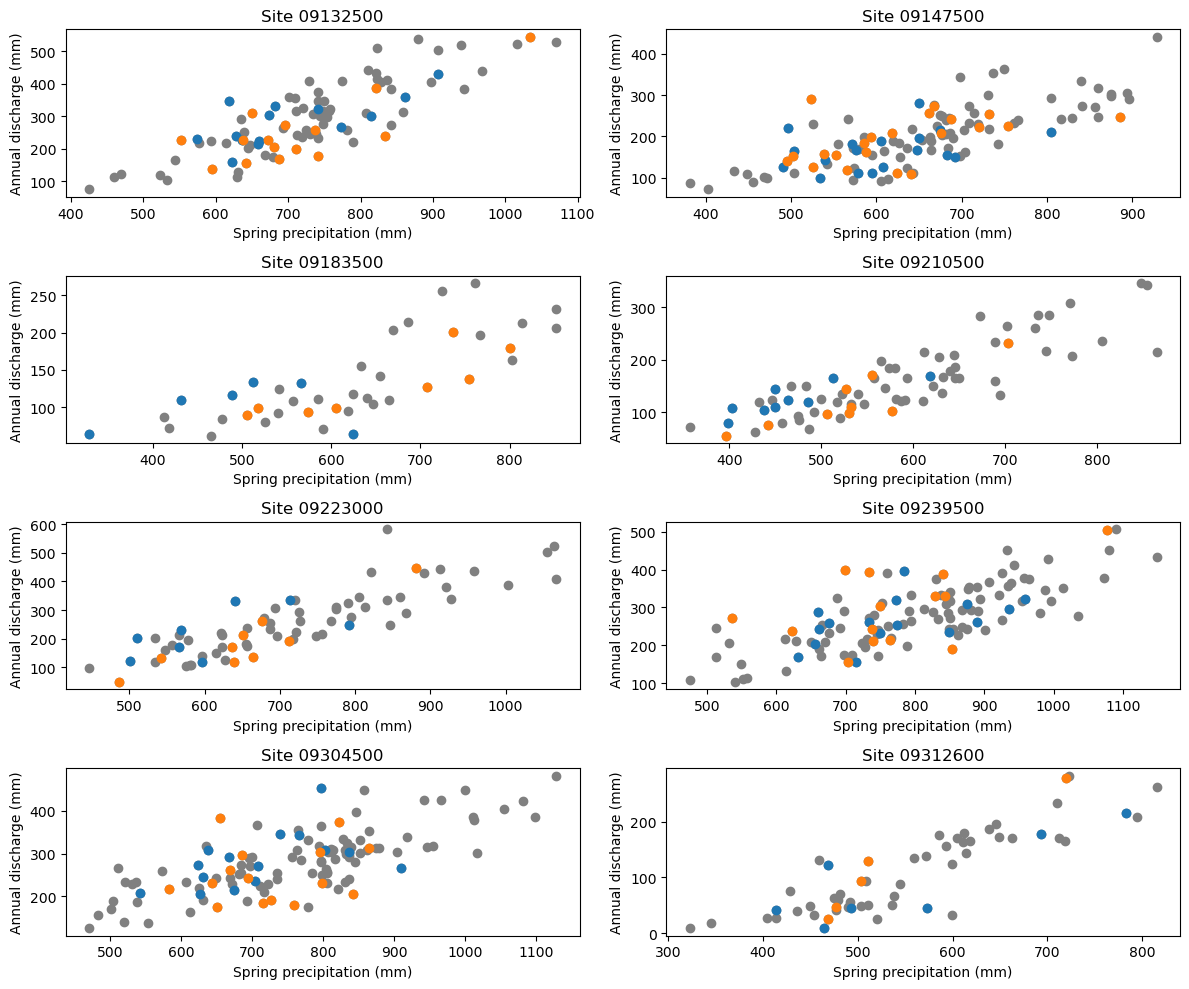

In [199]:
# Spring P vs annual q
# create an empty dataframe to store results with an index equal to low_elevation_annual_q.site_no
low_elevation_ttest = pd.DataFrame(index=low_elevation_annual_q.site_no, columns=['ranksum_pvalue', 'ttest_pvalue'])
fig, axs = plt.subplots(4,2, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(low_elevation_annual_q.site_no.values):
    tmp = low_elevation_annual_q.sel(site_no=site)
    tmp = tmp.where(tmp.q_mm>0, drop=True).q_mm
    # annual ppt
    tmp_ppt_annual = low_elevation_annual_ppt.sel(site_no=site)
    tmp_ppt_annual = tmp_ppt_annual.where(tmp_ppt_annual.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    # spring ppt
    tmp_ppt_spring = low_elevation_seasonal_ppt.sel(site_no=site).where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True)
    tmp_ppt_spring = tmp_ppt_spring.where(tmp_ppt_spring.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt_spring.index = tmp_ppt_spring.index.year
    # winter ppt
    tmp_ppt_winter = low_elevation_seasonal_ppt.sel(site_no=site).where(low_elevation_seasonal_ppt.month.dt.month==1, drop=True)
    tmp_ppt_winter = tmp_ppt_winter.where(tmp_ppt_winter.month.dt.year.isin(tmp.WY), drop=True).ppt.to_pandas()
    tmp_ppt_winter.index = tmp_ppt_winter.index.year

    # COMBINE INTO TEMPORARY DATAFRAME
    tmp_df = pd.concat([tmp.to_pandas(), tmp_ppt_annual, tmp_ppt_spring, tmp_ppt_winter], axis=1)
    tmp_df.columns = ['q_mm', 'ppt_mm', 'spring_ppt_mm', 'winter_ppt_mm']
    # create a ratio of spring ppt and annual ppt
    tmp_df['spring_ppt_ratio'] = tmp_df['spring_ppt_mm'] / tmp_df['ppt_mm']
    # create a ratio of winter ppt and annual ppt
    tmp_df['winter_ppt_ratio'] = tmp_df['winter_ppt_mm'] / tmp_df['ppt_mm']
    # grab the lowest quartile of ppt_mm
    ppt_mm_q1 = tmp_df['ppt_mm'].quantile(1)
    # grab years when spring ppt is in the lowest quartile and winter ppt is above average

    tmp_low_quartile = tmp_df[(tmp_df['spring_ppt_mm']<=tmp_df['spring_ppt_mm'].quantile(0.25)) & (tmp_df['winter_ppt_mm']>tmp_df['winter_ppt_mm'].quantile(0.35))]
    tmp_high_quartile = tmp_df[(tmp_df['winter_ppt_mm']<=tmp_df['winter_ppt_mm'].quantile(0.25)) & (tmp_df['spring_ppt_mm']>tmp_df['spring_ppt_mm'].quantile(0.35))]
    
    ax=axs[i]
    ax.scatter(tmp_df.ppt_mm, tmp_df.q_mm, label='all years', color='gray')
    ax.scatter(tmp_low_quartile.ppt_mm,tmp_low_quartile.q_mm, label='years with lowest quartile of spring ppt and\nhigher than average winter ppt')
    ax.scatter(tmp_high_quartile.ppt_mm,tmp_high_quartile.q_mm, label='years with lowest quartile of winter ppt and\nhigher than average spring ppt')                           
    # if i==0:
    #     ax.legend()
    ax.set_xlabel('Spring precipitation (mm)')
    ax.set_ylabel('Annual discharge (mm)')
    ax.set_title(f'Site {site}')              
           

### Percent Changes

In [206]:
high_spring_diff = (high_springp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
high_summer_diff = (high_summerp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
high_fall_diff = (high_fallp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
high_winter_diff = (high_winterp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
(high_spring_diff)/high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference']

09107000    0.509207
09110000    0.509207
09352900    0.368571
Name: value difference, dtype: object

In [205]:
mid_spring_diff = (mid_springp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
mid_summer_diff = (mid_summerp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
mid_fall_diff = (mid_fallp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
mid_winter_diff = (mid_winterp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
(mid_spring_diff)/mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference']

09081600    0.306947
09112500    0.334693
09115500    0.427867
09119000    0.467412
09146200    0.467015
09361500    0.345917
Name: value difference, dtype: object

In [204]:
low_spring_diff = (low_springp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
low_summer_diff = (low_summerp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
low_fall_diff = (low_fallp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
low_winter_diff = (low_winterp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
(low_spring_diff)/low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference']

09132500     0.39942
09147500    0.486661
09183500    0.411473
09210500    0.240964
09239500    0.358306
09304500    0.336375
Name: value difference, dtype: object

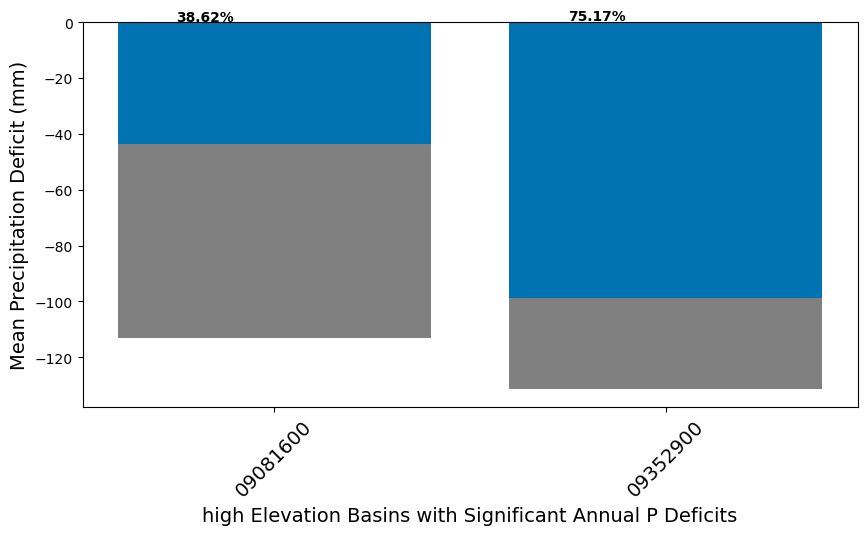

In [320]:
# create a bar plot with the value difference for high_annualp_ttest_results
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('colorblind')
ax.bar(high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05].index, high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'], color='grey')
ax.bar((high_spring_diff+high_summer_diff+high_winter_diff).index, (high_spring_diff+high_summer_diff),color=colors[0], label = 'Spring + Summer P Deficits')
# add a label on each bar with the percent of total
for i, v in enumerate((high_spring_diff+high_summer_diff)/high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference']):
    ax.text(i-.25, v + 0.01, str(round(100*v,2))+'%', color='black', fontweight='bold')
ax.set_ylabel('Mean Precipitation Deficit (mm)', size=14)
ax.set_xlabel('high Elevation Basins with Significant Annual P Deficits', size=14)
# increase x tick label size
ax.tick_params(axis='x', labelsize=14, rotation=45)

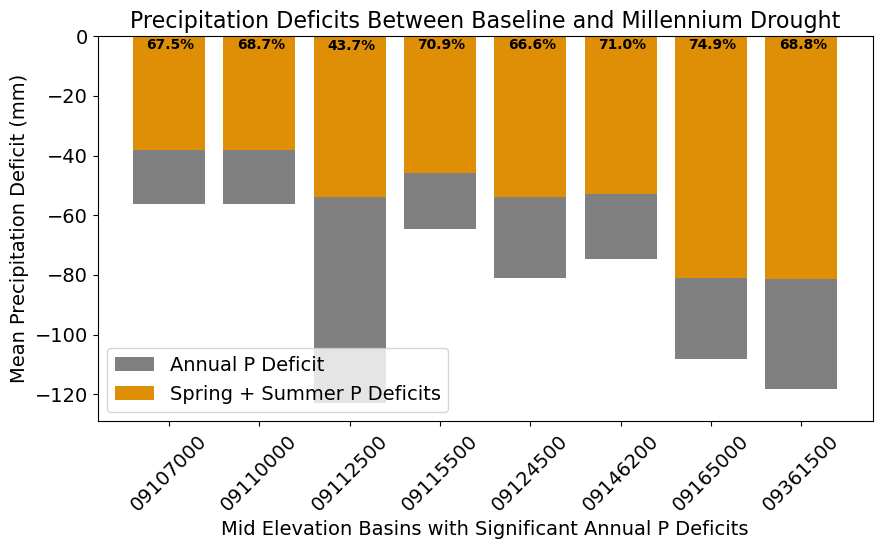

In [334]:
# create a bar plot with the value difference for mid_annualp_ttest_results
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('colorblind')
ax.bar(mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05].index, 
mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'], 
color='grey',
label = 'Annual P Deficit')
ax.bar((mid_spring_diff+mid_summer_diff+mid_winter_diff).index, 
(mid_spring_diff+mid_summer_diff),color=colors[1], 
label = 'Spring + Summer P Deficits')
# add a label on each bar with the percent of total
for i, v in enumerate((mid_spring_diff+mid_summer_diff)/mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference']):
    if i == 1:
        ax.text(i-.25, v-5, str(round(100*(v+0.0123),1))+'%', color='black', fontweight='bold')
    else:
        ax.text(i-.25, v-5, str(round(100*(v),1))+'%', color='black', fontweight='bold')
ax.set_ylabel('Mean Precipitation Deficit (mm)', size=14)
ax.set_xlabel('Mid Elevation Basins with Significant Annual P Deficits', size=14)
# increase x tick label size
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('Precipitation Deficits Between Baseline and Millennium Drought', size=16)
# add some space between title and plot
ax.title.set_position([.5, 1.1])
ax.legend(fontsize=14)

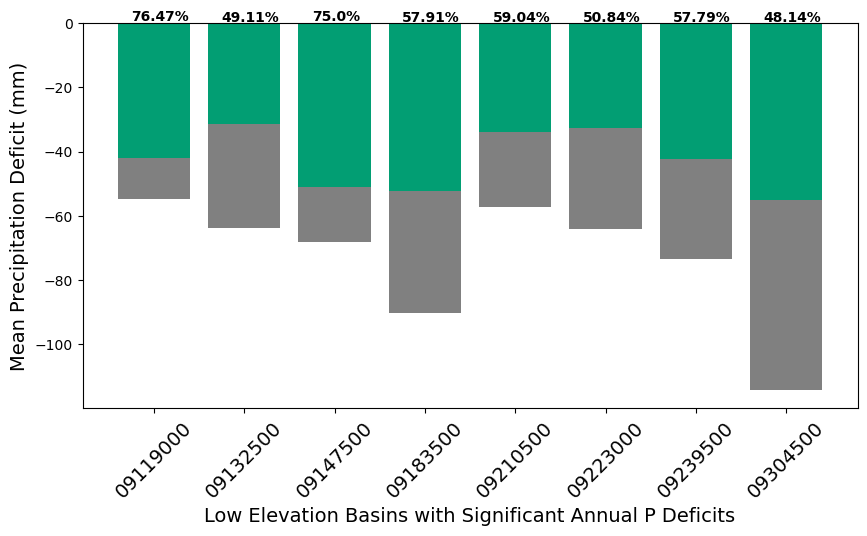

In [318]:
# create a bar plot with the value difference for low_annualp_ttest_results
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('colorblind')
ax.bar(low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05].index, low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'], color='grey')
ax.bar((low_spring_diff+low_summer_diff+low_winter_diff).index, (low_spring_diff+low_summer_diff),color=colors[2], label = 'Spring + Summer P Deficits')
# add a label on each bar with the percent of total
for i, v in enumerate((low_spring_diff+low_summer_diff)/low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference']):
    ax.text(i-.25, v + 0.01, str(round(100*v,2))+'%', color='black', fontweight='bold')
ax.set_ylabel('Mean Precipitation Deficit (mm)', size=14)
ax.set_xlabel('Low Elevation Basins with Significant Annual P Deficits', size=14)
# increase x tick label size
ax.tick_params(axis='x', labelsize=14, rotation=45)

In [ ]:
# create a bar plot with the value difference for mid_annualp_ttest_results
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05].index, mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'], color='grey')
ax.bar((mid_spring_diff+mid_summer_diff).index, (mid_spring_diff+mid_summer_diff),color='blue')

# Look at changes in runoff efficiency between periods

In [243]:
ucrb_annual_ppt = ucrb_ppt_seasonal_mean.groupby('WY').sum()
conf=0.05
ucrb_re_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p'
                                                                                    ])
single_site_pre = (ucrb_naturalized_streamflow['q_mm_day'].loc[test_start_year:1999]/ucrb_annual_ppt['ppt'].to_pandas().loc[test_start_year:1999])
single_site_post = (ucrb_naturalized_streamflow['q_mm_day'].loc[2000:2022]/ucrb_annual_ppt['ppt'].to_pandas().loc[2000:2022])
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_re_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_re_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_re_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_re_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_re_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_re_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_re_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_re_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_re_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [244]:
high_runoffeff_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    dataset = high_elevation_annual_q.where(high_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    single_site_pre = (dataset['q_mm']/dataset['ppt']).to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = (dataset['q_mm']/dataset['ppt']).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_runoffeff_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        high_runoffeff_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_runoffeff_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_runoffeff_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_runoffeff_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [245]:
high_runoffeff_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09034900        0.424786                                  Probably Gaussian   
09035900        0.401196                                  Probably Gaussian   
09047700        0.437259                                  Probably Gaussian   
09065500        0.001716  Probably not Gaussian, consider a non-parametr...   
09066000        0.223814                                  Probably Gaussian   
09066200        0.094283                                  Probably Gaussian   
09107000        0.820613                                  Probably Gaussian   
09110000        0.016216  Probably not Gaussian, consider a non-parametr...   
09124500        0.800356                                  Probably Gaussian   
09352900         0.47211                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09034900    0.093  Null Hypothesis Accepted           NaN   
09035900    0.724  Null Hypothesis Accepted           NaN   
09047700    0.387  Null Hypothesis Accepted           NaN   
09065500      NaN                       NaN         0.953   
09066000    0.407  Null Hypothesis Accepted           NaN   
09066200    0.014  Null Hypothesis Rejected           NaN   
09107000    0.875  Null Hypothesis Accepted           NaN   
09110000      NaN                       NaN         0.971   
09124500    0.358  Null Hypothesis Accepted           NaN   
09352900    0.871  Null Hypothesis Accepted           NaN   

                mannwhitney Result percent change value difference  
09034900                       NaN          -6.52            -0.06  
09035900                       NaN           1.94             0.01  
09047700                       NaN          -6.52            -0.03  
09065500  Null Hypothesis Accepted          -9.68            -0.09  
09066000                       NaN          -5.57            -0.03  
09066200                       NaN         -12.56            -0.12  
09107000                       NaN           1.25             0.01  
09110000  Null Hypothesis Accepted          -2.91            -0.01  
09124500                       NaN           10.4             0.03  
09352900                       NaN          -0.75            -0.01

In [246]:
mid_runoffeff_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    dataset = mid_elevation_annual_q.where(mid_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    single_site_pre = (dataset['q_mm']/dataset['ppt']).to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = (dataset['q_mm']/dataset['ppt']).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_runoffeff_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        mid_runoffeff_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_runoffeff_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    mid_runoffeff_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    mid_runoffeff_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [247]:
mid_runoffeff_ttest_results

Shapiro-Wilke p                               Shapiro-Wilke Result  \
09066300        0.049832  Probably not Gaussian, consider a non-parametr...   
09081600        0.795698                                  Probably Gaussian   
09112500        0.091566                                  Probably Gaussian   
09115500        0.077296                                  Probably Gaussian   
09119000        0.324259                                  Probably Gaussian   
09146200        0.265387                                  Probably Gaussian   
09165000        0.439269                                  Probably Gaussian   
09361500        0.735512                                  Probably Gaussian   

         t-test p             t-test Result mannwhitney p  \
09066300      NaN                       NaN         0.979   
09081600     0.94  Null Hypothesis Accepted           NaN   
09112500    0.837  Null Hypothesis Accepted           NaN   
09115500    0.556  Null Hypothesis Accepted           NaN   
09119000    0.549  Null Hypothesis Accepted           NaN   
09146200    0.723  Null Hypothesis Accepted           NaN   
09165000    0.528  Null Hypothesis Accepted           NaN   
09361500    0.902  Null Hypothesis Accepted           NaN   

                mannwhitney Result percent change value difference  
09066300  Null Hypothesis Accepted         -14.72            -0.08  
09081600                       NaN            0.4              0.0  
09112500                       NaN           1.72             0.01  
09115500                       NaN           9.81             0.02  
09119000                       NaN          21.89             0.02  
09146200                       NaN           1.96             0.01  
09165000                       NaN          -4.56            -0.02  
09361500                       NaN          -0.97             -0.0

In [248]:
low_runoffeff_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    dataset = low_elevation_annual_q.where(low_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    single_site_pre = (dataset['q_mm']/dataset['ppt']).to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = (dataset['q_mm']/dataset['ppt']).to_pandas().dropna().loc[2000:2021]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_runoffeff_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        low_runoffeff_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_runoffeff_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    low_runoffeff_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    low_runoffeff_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [273]:
high_runoffeff_ttest_results.index

Index(['09034900', '09035900', '09047700', '09065500', '09066000', '09066200',
       '09107000', '09110000', '09124500', '09352900'],
      dtype='object')

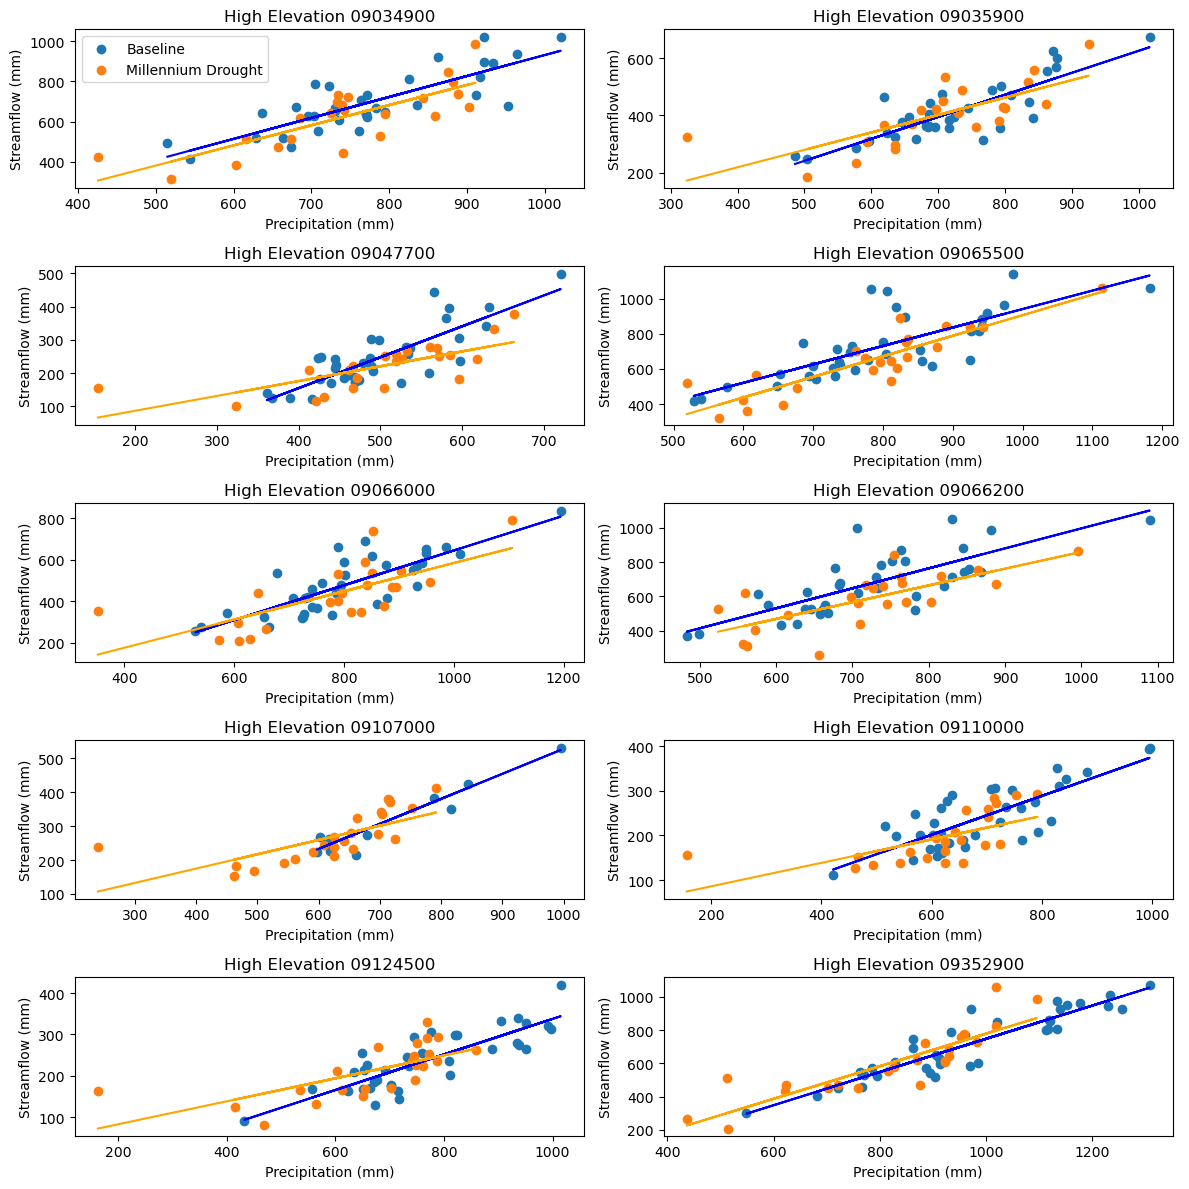

In [253]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,12), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(high_elevation_annual_q.site_no.values):
    dataset = high_elevation_annual_q.where(high_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    
    ax = axs[i]
    ax.scatter(dataset.sel(WY=slice(1964,1999)).ppt,
                dataset.sel(WY=slice(1964,1999)).q_mm, label='Baseline')
    
    
    # add a best fit line for each period
    x = dataset.sel(WY=slice(1964,1999)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='blue')
    ax.scatter(dataset.sel(WY=slice(2000,2022)).ppt,
                dataset.sel(WY=slice(2000,2022)).q_mm,label='Millennium Drought')
    # add a best fit line for each period
    x = dataset.sel(WY=slice(2000,2022)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(2000,2022)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='orange')
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Streamflow (mm)')
    ax.set_title(f'High Elevation {site}')
    if i==0:
        ax.legend()

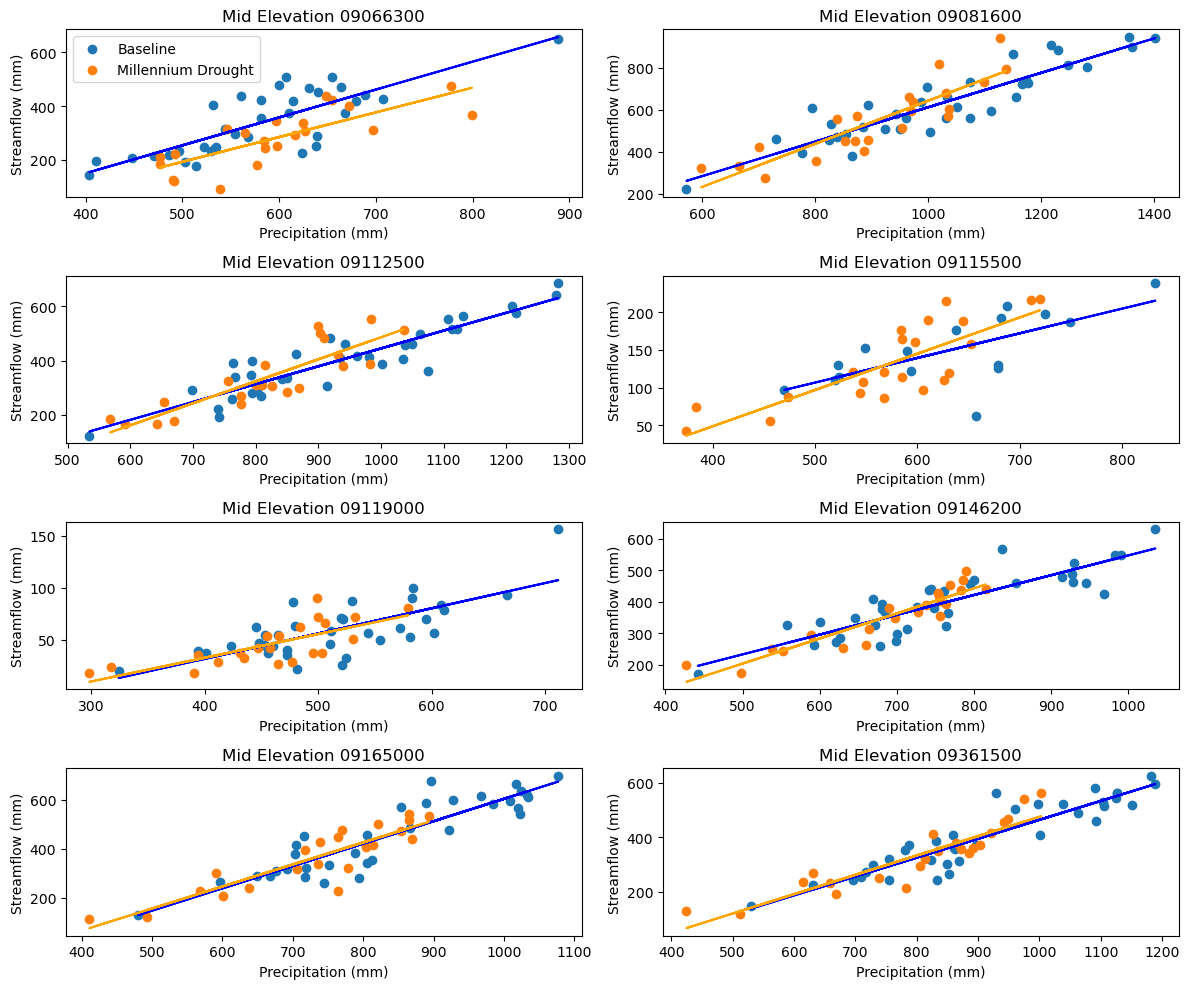

In [254]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(mid_elevation_annual_q.site_no.values):
    dataset = mid_elevation_annual_q.where(mid_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    # remove the WY with the least ppt
    dataset = dataset.where(dataset.ppt!=dataset.ppt.min(), drop=True)
    ax = axs[i]
    ax.scatter(dataset.sel(WY=slice(1964,1999)).ppt,
                dataset.sel(WY=slice(1964,1999)).q_mm, label='Baseline')
    
    
    # add a best fit line for each period
    x = dataset.sel(WY=slice(1964,1999)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='blue')
    ax.scatter(dataset.sel(WY=slice(2000,2022)).ppt,
                dataset.sel(WY=slice(2000,2022)).q_mm,label='Millennium Drought')
    # add a best fit line for each period
    x = dataset.sel(WY=slice(2000,2022)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(2000,2022)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='orange')
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Streamflow (mm)')
    ax.set_title(f'Mid Elevation {site}')
    if i==0:
        ax.legend()

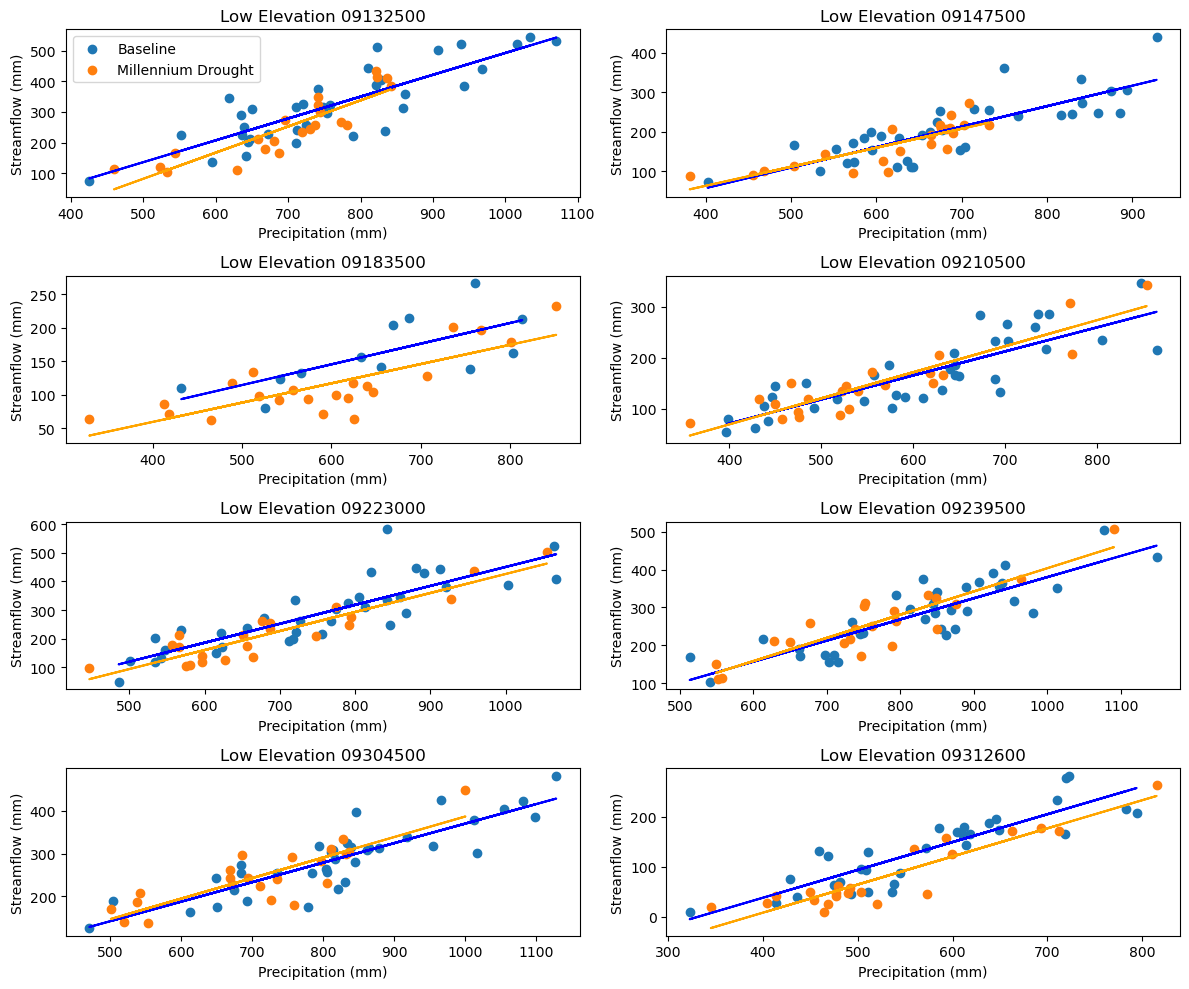

In [255]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(low_elevation_annual_q.site_no.values):
    dataset = low_elevation_annual_q.where(low_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    # remove the WY with the least ppt
    dataset = dataset.where(dataset.ppt!=dataset.ppt.min(), drop=True)
    ax = axs[i]
    ax.scatter(dataset.sel(WY=slice(1964,1999)).ppt,
                dataset.sel(WY=slice(1964,1999)).q_mm, label='Baseline')
    
    
    # add a best fit line for each period
    x = dataset.sel(WY=slice(1964,1999)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='blue')
    ax.scatter(dataset.sel(WY=slice(2000,2022)).ppt,
                dataset.sel(WY=slice(2000,2022)).q_mm,label='Millennium Drought')
    # add a best fit line for each period
    x = dataset.sel(WY=slice(2000,2022)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(2000,2022)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='orange')
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Streamflow (mm)')
    ax.set_title(f'Low Elevation {site}')
    if i==0:
        ax.legend()

### Figure Mock Up

In [256]:
# get the sites in the high, mid and low meanq results that are Rejected
high_meanq_rejected = high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                  (high_meanq_ttest_results['mannwhitney p']<0.05)].index.values 
mid_meanq_rejected = mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                (mid_meanq_ttest_results['mannwhitney p']<0.05)].index.values      
low_meanq_rejected = low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                (low_meanq_ttest_results['mannwhitney p']<0.05)].index.values  
# combine these into a single array
all_meanq_rejected = np.concatenate((high_meanq_rejected, mid_meanq_rejected, low_meanq_rejected))     

# get the sites in the high, mid and low meanq results with t-test p-values >0.05 and less than 0.10
high_meanq_ttest_p10 = high_meanq_ttest_results[((high_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['t-test p']<=0.10)) |
                                                   ((high_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['mannwhitney p']<=0.10)) ].index.values
mid_meanq_ttest_p10 = mid_meanq_ttest_results[((mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['t-test p']<=0.10)) |
                                                    ((mid_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['mannwhitney p']<=
                                                     0.10)) ].index.values
low_meanq_ttest_p10 = low_meanq_ttest_results[((low_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['t-test p']<=0.10)) |
                                                    ((low_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['mannwhitney p']<=0.10)) ].index.values
# combine these into a single array
all_meanq_ttest_p10 = np.concatenate((high_meanq_ttest_p10, mid_meanq_ttest_p10, low_meanq_ttest_p10))

# get the sites in the high, mid and low meanq results with t-test p-values >0.05 and less than 0.10
high_meanq_ttest_acc = high_meanq_ttest_results[((high_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['t-test p']>0.10)) |
                                                   ((high_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['mannwhitney p']>0.10)) ].index.values
mid_meanq_ttest_acc = mid_meanq_ttest_results[((mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['t-test p']>0.10)) |
                                                    ((mid_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['mannwhitney p']>0.10)) ].index.values
low_meanq_ttest_acc = low_meanq_ttest_results[((low_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['t-test p']>0.10)) |
                                                    ((low_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['mannwhitney p']>0.10)) ].index.values
# combine these into a single array
all_meanq_ttest_acc = np.concatenate((high_meanq_ttest_acc, mid_meanq_ttest_acc, low_meanq_ttest_acc))

In [257]:
# get the sites in the high, mid, and low meanq percent change
high_meanq_percentchange = high_meanq_ttest_results['percent change']
mid_meanq_percentchange = mid_meanq_ttest_results['percent change']
low_meanq_percentchange = low_meanq_ttest_results['percent change']
# combine these into a single series
all_meanq_percentchange = pd.concat([high_meanq_percentchange, mid_meanq_percentchange, low_meanq_percentchange])

# get the sites in the high, mid and low springp results that are percent change
high_springp_percentchange = high_springp_ttest_results['percent change']
mid_springp_percentchange = mid_springp_ttest_results['percent change']
low_springp_percentchange = low_springp_ttest_results['percent change']
# combine these into a single series
all_springp_percentchange = pd.concat([high_springp_percentchange, mid_springp_percentchange, low_springp_percentchange])

# pull in the PRISM percent diff 
prism_springp_diff = xr.open_dataset('../data/precipdata/springP_prism_percentdiff.nc')

# Import DEM for hillshade

In [266]:
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
src_4km = rxr.open_rasterio('../basin_characteristics/ucrb_dem_32613_150m.tif')
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
# downsample to 800m
src_4km = src_4km.rio.reproject(dst_crs='EPSG:32613', resolution=3945.843241747955)
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
ls = LightSource(azdeg=315, altdeg=45)
dx, dy =3945.843241747955,3945.843241747955

# Import HCDN basins

In [267]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

/tmp/ipykernel_18857/4222011424.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


(-148750.26486232155, 446464.52843976894, 3938943.52723589, 4823274.522415304)

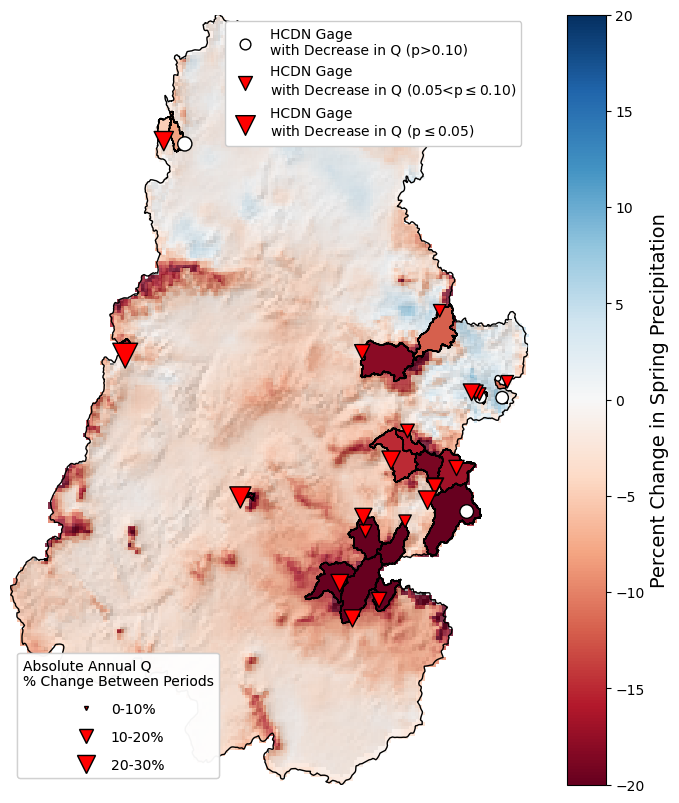

In [268]:
# import gage locations
gage_locations = gpd.read_file('../data/geodata/ucrb_hcdn_merged_gages.geojson')
# import hcdn basins
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
# filter basins in hcdn_daily_q
hcdn_basins = hcdn_basins[hcdn_basins['gage'].isin(hcdn_daily_q.site_no.values)]
hcdn_basins = hcdn_basins.set_crs('EPSG:32613', allow_override=True)
# set index col to be 'gage' column
hcdn_basins = hcdn_basins.set_index('gage')
# import the UCRB basin boundary
ucrb_basin = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
# set the crs to the same as hcdn basins
gage_locations = gage_locations.to_crs(hcdn_basins.crs)
ucrb_basin = ucrb_basin.to_crs(hcdn_basins.crs)


# add 0 to the beginning of the site_no to match the format in the hcdn_daily_q dataframe
gage_locations['STAID'] = '0' + gage_locations['STAID'].astype(str)
# filter out the gages not included in the analysis
gage_locations = gage_locations[gage_locations['STAID'].isin(hcdn_daily_q.site_no.values)]
# reset index
gage_locations = gage_locations.set_index('STAID')
# add all_meanq_percentchange as a column in the gage_locations dataframe
gage_locations['meanq_percentchange'] = np.abs(all_meanq_percentchange.astype(int))*8

# add all_springp_percentchange as a column in the hcdn_basins dataframe
hcdn_basins['springp_percentchange'] = (all_springp_percentchange.astype(int))

# create a fig and ax
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['maxy']])
# plot the prism percent diff
im = ax.imshow(prism_springp_diff['ppt'].values,
                       cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])               
# plot the hcdn basins
hcdn_basins.plot(ax=ax, 
                 column='springp_percentchange',
                 cmap='RdBu', 
                 edgecolor='black', 
                 linewidth=1,
                 vmin=-20, 
                 vmax=20)
# plot a legend for the colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-20, vmax=20))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('Percent Change in Spring Precipitation', fontsize=14)
# plot the ucrb basins
ucrb_basin.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# plot the gage location geometry with sizes based on all_meanq_percentchange
gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)].plot(markersize=gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)]['meanq_percentchange'], 
                    label='HCDN Gage\nwith Decrease in Q (p>0.10)', 
                    marker='o', 
                    ax=ax, 
                    color='white', 
                    ec='k')
# plot gage locations with significant change in meanq                    
gage_locations.loc[all_meanq_ttest_p10].plot(markersize=gage_locations.loc[all_meanq_ttest_p10]['meanq_percentchange'],
                                            label='HCDN Gage\nwith Decrease in Q (0.05<p$\leq$0.10)', 
                                            marker='v', 
                                            ax=ax, 
                                            color='red', 
                                            ec='k')
# plot gage locations with significant change in meanq                    
gage_locations.loc[all_meanq_rejected].plot(markersize=gage_locations.loc[all_meanq_rejected]['meanq_percentchange'],
                                            label='HCDN Gage\nwith Decrease in Q (p$\leq$0.05)', 
                                            marker='v', 
                                            ax=ax, 
                                            color='red', 
                                            ec='k')
# create a legend for the gage locations
# need to add existing legend back

leg1 = ax.legend(loc='upper right',framealpha=1)
# create a second legend for the size of the gage locations
# some bins to indicate size in legend
_, bins = pd.cut(gage_locations['meanq_percentchange']/8, bins=[1,11,21], precision=0, retbins=True)
# create second legend
import matplotlib.lines as mlines
# create label for each bin with a range between the bin values
labels = [str(int(b-1))+'-'+str(int(bins[i]-1+10))+'%' for i, b in enumerate(bins)]
# labels.append(str(int(bins[-1]))+'%+')
ax.add_artist(
    ax.legend(
        handles=[
            mlines.Line2D(
                [],
                [],
                color="red",
                lw=0,
                marker="v",
                markeredgecolor='k',
                markersize=np.sqrt(b*8),
                label=labels[i],
            )
            for i, b in enumerate(bins)
        ],
        loc='lower left',
        # make distance between legend items a bit bigger
        labelspacing=1,
        # add title to the legend
        title='Absolute Annual Q\n% Change Between Periods',
    )
)
# restore original legend
ax.add_artist(leg1)
# remove axis labels
ax.axis('off')

### ANOVA testing for differences between basins in pre- and post-2000 streamflow

In [79]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
dates = [date2DOWY(x) for x in hcdn_daily_q.date.values]
dowy_da = pd.Series(dates,index=hcdn_daily_q.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_ds = hcdn_daily_q.copy()
hcdn_q_dowy_ds = hcdn_q_dowy_ds.merge(dowy_da)
hcdn_q_dowy_spsu_ds = hcdn_q_dowy_ds.where(hcdn_q_dowy_ds.date.dt.month.isin([3,4,5,6,7,8,9,10]), drop=True)

In [80]:
hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY<2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_pre2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_pre2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_pre2000_ds.merge(dowy_da)

In [81]:
hcdn_q_dowy_post2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY>=2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_post2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_post2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_post2000_ds = hcdn_q_dowy_post2000_ds.merge(dowy_da)

In [82]:
hcdn_q_dowy_mean = hcdn_q_dowy_spsu_ds.groupby('dowy').mean()
hcdn_q_dowy_pre2000_mean = hcdn_q_dowy_pre2000_ds.groupby('dowy').mean()
hcdn_q_dowy_post2000_mean = hcdn_q_dowy_post2000_ds.groupby('dowy').mean()

6.378322826263686
0.0017934681352298782


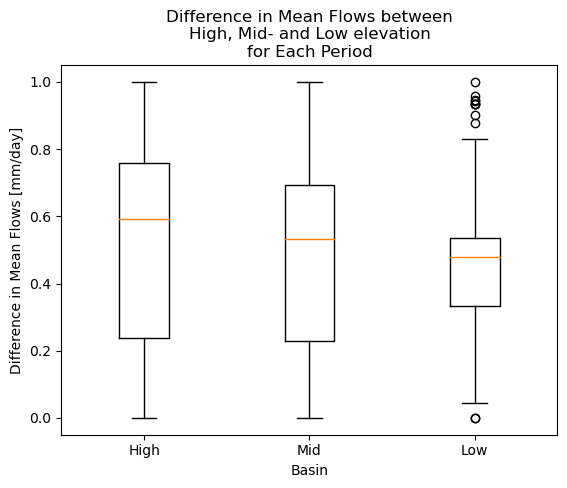

In [78]:
site_diff_high = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_mid = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_low = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']))
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))
print(fvalue)
print(pvalue)
# Using boxplot, we can start to visually see differences between the periods
plt.boxplot([((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))],
           labels=['High', 'Mid', 'Low'])

# Add labels
plt.xlabel('Basin')
plt.ylabel('Difference in Mean Flows [mm/day]')
plt.title('Difference in Mean Flows between\nHigh, Mid- and Low elevation\nfor Each Period');

Prior to running our test, lets test to make sure our data is valid for using this test

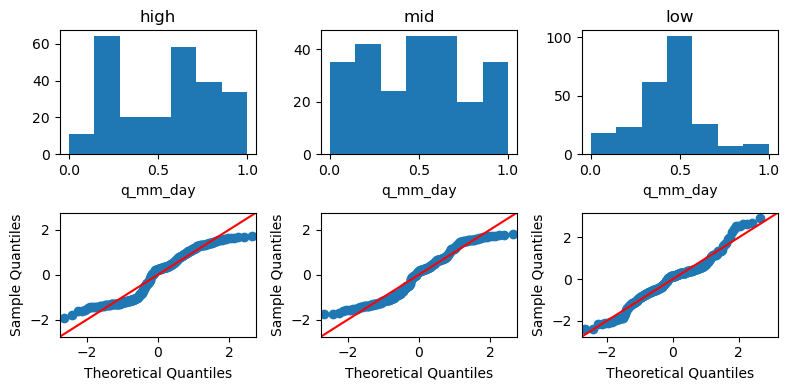

In [79]:
# test for normality 
fig, axs = plt.subplots(ncols=3, nrows=2, tight_layout=True, figsize=(8,4))
val_list = [((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))]
val_title =['high', 'mid', 'low']
for i, val in enumerate(val_list):
    val.plot.hist(ax=axs[0,i], bins=7)
    axs[0,i].set_title(val_title[i])

    sm.qqplot((val-val.mean())/val.std(), line ='45', ax=axs[1,i]);


Fails the Bartlett test which tests for equal variance

In [80]:
stats.bartlett(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min()))),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))

<xarray.DataArray 'q_mm_day' (dowy: 246)>
array([5.74392642e-01, 6.10382086e-01, 5.32735608e-01, 5.48752500e-01,
       5.52848543e-01, 6.49761675e-01, 6.25743972e-01, 5.48043096e-01,
       5.42409552e-01, 5.55183914e-01, 5.38633840e-01, 5.12146445e-01,
       4.53781281e-01, 5.04695064e-01, 5.19257414e-01, 4.93173381e-01,
       5.21223085e-01, 5.00570658e-01, 4.77851782e-01, 5.08511567e-01,
       5.05160446e-01, 5.27233602e-01, 5.43152687e-01, 5.24693671e-01,
       5.54807201e-01, 5.56958273e-01, 4.55596803e-01, 5.01233233e-01,
       5.21936585e-01, 5.00693131e-01, 4.81098891e-01, 4.05564235e-01,
       4.63092784e-01, 4.75336861e-01, 4.89353588e-01, 4.88633406e-01,
       5.05853234e-01, 5.22440682e-01, 5.40848085e-01, 4.99150947e-01,
       5.00686326e-01, 5.18026746e-01, 5.74013440e-01, 6.67911612e-01,
       7.07211054e-01, 7.58491080e-01, 7.72177569e-01, 8.25277054e-01,
       8.76951468e-01, 9.34015440e-01, 9.33494270e-01, 9.44681241e-01,
       9.57182681e-01, 1.00000000e+00, 9.44892337e-01, 9.33581598e-01,
       9.02807025e-01, 8.30691566e-01, 8.11327901e-01, 7.69230691e-01,
       7.47066173e-01, 7.07741794e-01, 6.67326626e-01, 7.09955887e-01,
       7.04207275e-01, 6.32396148e-01, 6.07009574e-01, 6.23192068e-01,
       5.82116227e-01, 6.59391986e-01, 6.66665810e-01, 7.00052562e-01,
       6.75871958e-01, 6.47451194e-01, 6.63145113e-01, 6.76602917e-01,
       6.69313293e-01, 6.04372200e-01, 5.54778243e-01, 5.20564392e-01,
...
       3.10778287e-01, 3.21526349e-01, 3.31106695e-01, 3.28851284e-01,
       3.34987504e-01, 3.24783743e-01, 3.42935157e-01, 3.29005915e-01,
       3.47080171e-01, 3.81237676e-01, 4.32553549e-01, 3.87985222e-01,
       3.91438908e-01, 3.99389645e-01, 4.29811072e-01, 4.15404634e-01,
       4.20271092e-01, 4.69481501e-01, 4.81375513e-01, 5.83598832e-01,
       5.22846711e-01, 5.33514348e-01, 5.06003862e-01, 4.85119262e-01,
       5.66076414e-01, 5.32847871e-01, 5.30654413e-01, 4.90580629e-01,
       5.01359947e-01, 5.01506294e-01, 5.36731121e-01, 5.22691326e-01,
       5.24561818e-01, 4.77840234e-01, 4.89033695e-01, 5.89798460e-01,
       4.79447273e-01, 4.79155145e-01, 5.06381031e-01, 4.97886945e-01,
       4.86847737e-01, 5.10283972e-01, 5.42391176e-01, 4.80960321e-01,
       5.16693974e-01, 4.72724473e-01, 4.93211119e-01, 5.10129474e-01,
       5.07604679e-01, 5.06619341e-01, 4.70805619e-01, 5.02367330e-01,
       4.41130469e-01, 3.99521486e-01, 4.34111647e-01, 5.25200369e-01,
       5.60686913e-01, 4.91002666e-01, 4.03094146e-01, 3.49517431e-01,
       3.55696355e-01, 4.58325322e-01, 4.14460135e-01, 4.33264388e-01,
       3.30133639e-01, 3.48490890e-01, 3.06206525e-01, 2.82726773e-01,
       3.66936479e-01, 4.80386079e-01, 4.03298033e-01, 3.61203825e-01,
       3.53705621e-01, 3.66870765e-01, 4.84293811e-01, 4.79282562e-01,
       4.47758002e-01, 3.11576919e-01])
Coordinates:
  * dowy     (dowy) float64 0.0 1.0 2.0 3.0 4.0 ... 362.0 363.0 364.0 365.0

In [81]:
site_diff_high['elevation_cluster'] = 'high'
site_diff_mid['elevation_cluster'] = 'mid'
site_diff_low['elevation_cluster'] = 'low'

In [82]:
df_reshaped = pd.concat([site_diff_high.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         site_diff_mid.to_dataframe()[['elevation_cluster','q_mm_day']],
                         site_diff_low.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         ]).reset_index()
# perform multiple pairwise comparison (Tukey HSD), 
# endog is response variable, groups are the tested groups to compare
period_comp = pairwise_tukeyhsd(endog=df_reshaped['q_mm_day'], groups=df_reshaped['elevation_cluster'], alpha=0.05)

# display the results table
print(period_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low  -0.0724 0.0001 -0.1117 -0.033   True
  high    mid  -0.0233 0.3468 -0.0626 0.0161  False
   low    mid   0.0491 0.0098  0.0097 0.0884   True
---------------------------------------------------


The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

In [83]:
stats.kruskal(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))

KruskalResult(statistic=13.579860214429296, pvalue=0.0011250474041236997)